# Sparse Bottleneck Networks for Exploratory Analysis and Visualization of Neural Patch-seq Data

In [1]:
# Import packages
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib
import seaborn as sns
import sparseRRR
import matplotlib
import matplotlib.pyplot as plt
import importlib

import bottleneck_networks

import time
import pickle
import warnings

dtype = tf.float32

def sns_styleset():
    sns.set_style('ticks', {'axes.linewidth': .75, "xtick.major.size":4, "ytick.major.size":4})

# Loading data

For pre-processing (gene selection, delete ephys-rna mismatches, delete low rna quality cells, ...) of the raw data check BottleneckNN_preprocessing.

In [2]:
M1_ephys = pd.read_csv('data/ephys_values.csv', index_col=0)
rpkm = pd.read_csv('data/gene_counts.csv', index_col='gene')
geneNames = np.array(list(rpkm.index))

In [3]:
# Now specify for all the cells left what the cell type is (according to transcriptomic mappings)
prop = pd.read_csv('data/mini-atlas-meta-data.csv', sep = '\t')
prop = prop.rename(columns = {'Sample': 'sample_id', 'Targeted layer': 'Layer'})
prop = prop[['Cell', 'RNA type', 'sample_id', 'Layer', 'Cre', 'RNA type top-3']]
sample_name = ['{}{}{}'.format(g.split('_')[0], g.split('_')[1], g.split('_')[2]) for g in prop['Cell']]
prop['sample name'] = sample_name
prop = prop.set_index('sample name')

prop = prop.reindex(M1_ephys.index) # There could be more cells with ephys than manually labelled
                                    # They will receive the Nan property
prop = prop.fillna('')
M1_Allen_Mapping = prop['RNA type']
M1_Allen_Mapping[np.where(M1_Allen_Mapping == '')[0]] = 'low quality'
number_labels = {c: i for i, c in enumerate(np.unique(M1_Allen_Mapping))}
cellTypes = np.array([number_labels[cell_type] for cell_type in M1_Allen_Mapping])

In [4]:
print('Double check:\n')
print('RPKM shape: ', rpkm.shape)
print('ephys shape: ', M1_ephys.shape)
print('cellTypes shape: ', cellTypes.shape)

Double check:

RPKM shape:  (1000, 1213)
ephys shape:  (1213, 16)
cellTypes shape:  (1213,)


In [34]:
cellTypeColors = {'Lamp5 Pax6': '#DDACC9', 'Lamp5 Egln3_1': '#FF88AD', 'Lamp5 Egln3_2': '#DD8091', 'Lamp5 Egln3_3': '#F08E98',
 'Lamp5 Pdlim5_1': '#FF7290', 'Lamp5 Pdlim5_2': '#FF8C97', 'Lamp5 Slc35d3': '#FFA388', 'Lamp5 Lhx6': '#C77963',
 'Sncg Col14a1': '#7E0ACB', 'Sncg Slc17a8': '#9440F3', 'Sncg Calb1_1': '#9611B6', 'Sncg Calb1_2': '#9900B3',
 'Sncg Npy2r': '#7A0099', 'Vip Sncg': '#AA4DB5', 'Vip Serpinf1_1': '#A720FF', 'Vip Serpinf1_2': '#AB1DFF',
 'Vip Serpinf1_3': '#FF5FCD', 'Vip Htr1f': '#FF4DC1', 'Vip Gpc3': '#B09FFF', 'Vip C1ql1': '#BD3D9A',
 'Vip Mybpc1_1': '#F70CF3', 'Vip Mybpc1_2': '#992E81', 'Vip Mybpc1_3': '#AB379C', 'Vip Chat_1': '#FF00FF',
 'Vip Chat_2': '#B3128A', 'Vip Igfbp6_1': '#7779BF', 'Vip Igfbp6_2': '#626EB8', 'Sst Chodl': '#FFFF00',
 'Sst Penk': '#FF8011', 'Sst Myh8_1': '#FF9F2C', 'Sst Myh8_2': '#FFB307', 'Sst Myh8_3': '#FFBF09',
 'Sst Htr1a': '#BFAF00', 'Sst Etv1': '#FFB22B', 'Sst Pvalb Etv1': '#D9C566', 'Sst Crhr2_1': '#BE8652',
 'Sst Crhr2_2': '#B0993C', 'Sst Hpse': '#CDB115', 'Sst Calb2': '#D2A328', 'Sst Pvalb Calb2': '#784F14',
 'Sst Pappa': '#635821', 'Sst C1ql3_1': '#802600', 'Sst C1ql3_2': '#8A2B1A', 'Sst Tac2': '#804600',
 'Sst Th_1': '#8C6012', 'Sst Th_2': '#A81111', 'Sst Th_3': '#9B211B', 'Pvalb Gabrg1': '#ED4C50',
 'Pvalb Egfem1': '#C05661', 'Pvalb Gpr149': '#E62A5D', 'Pvalb Kank4': '#BC4B11', 'Pvalb Calb1_1': '#B6411E',
 'Pvalb Calb1_2': '#BC2D71', 'Pvalb Reln': '#9C4165', 'Pvalb Il1rapl2': '#BC2C41', 'Pvalb Vipr2_1': '#FF197F',
 'Pvalb Vipr2_2': '#F4358B', 'L2/3 IT_1': '#00FF34', 'L2/3 IT_2': '#07D945', 'L2/3 IT_3': '#2EB934',
 'L4/5 IT_1': '#09CCC6', 'L4/5 IT_2': '#52B8AA', 'L5 IT_1': '#58D2C1', 'L5 IT_2': '#4A9F93', 'L5 IT_3': '#4EAC9C',
 'L5 IT_4': '#52B4B8', 'L6 IT_1': '#B2AD23', 'L6 IT_2': '#81791F', 'L6 IT Car3': '#5100FF', 'L5 PT_1': '#0D5D7E',
 'L5 PT_2': '#0B77A5', 'L5 PT_3': '#0B8AA5', 'L5 PT_4': '#0A75B1', 'L5/6 NP_1': '#48CB80', 'L5/6 NP_2': '#3C78BC',
 'L5/6 NP_3': '#47867A', 'L5/6 NP CT': '#1AAB99', 'L6 CT Gpr139': '#168577', 'L6 CT Cpa6': '#338C5E', 'L6 CT Grp': '#2FBCE5',
 'L6 CT Pou3f2': '#3E766C', 'L6 CT Kit_1': '#516B78', 'L6 CT Kit_2': '#557361', 'L6b Col6a1': '#69419D',
 'L6b Shisa6_1': '#46306A', 'L6b Shisa6_2': '#464576', 'L6b Ror1': '#7044AA', 'L6b Kcnip1': '#573D90'}

# Normalization of data

In [35]:
# Preprocess subset of the data in a systematic manner (library normalization and Z-scoring)
geneNames = np.array(list(rpkm.index))
Y = M1_ephys.values
X = rpkm.values.astype(np.float).T
X = X / np.sum(X, axis=1, keepdims=True) * \
                np.median(np.sum(X, axis=1, keepdims=True))

# Log-transform
X = np.log2(X + 1)

# Sort out cells with nans in the transcriptomic data
ind_non_nan = ~np.isnan(np.sum(X, axis=1))
X = X[ind_non_nan, :]
Y = Y[ind_non_nan, :]
cellTypes = cellTypes[ind_non_nan]

# Standardize Y
mu = np.mean(Y, axis=0)
Y = Y - mu
sigma = np.std(Y, axis=0)
Y = Y / sigma

# Standardize X
mu = np.mean(X, axis=0)
X = X - mu
sigma = np.std(X, axis=0)
X = X / sigma

X_no_low_qual = X.astype('float32')
Y_no_low_qual = Y.astype('float32')

In [36]:
# Preprocess subset of the data in a systematic manner (library normalization and Z-scoring)
# geneNames = np.array(list(rpkm.index))
# Y = M1_ephys.values
# X = rpkm.values.astype(np.float).T
# X = X / np.sum(X, axis=1, keepdims=True) * \
#                 np.median(np.sum(X, axis=1, keepdims=True))

# # Log-transform
# X = np.log2(X + 1)

# # Sort out cells with nans in the transcriptomic data
# ind_non_nan = ~np.isnan(np.sum(X, axis=1))
# X = X[ind_non_nan, :]
# Y = Y[ind_non_nan, :]
# cellTypes = cellTypes[ind_non_nan]

# # Choose numbers between you'd like to normalize
# a=0
# b=1
# X = (b-a)*(X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0)) + a
# Y = (b-a)*(Y - np.min(Y, axis=0)) / (np.max(Y, axis=0) - np.min(Y, axis=0)) + a
# X_no_low_qual = X.astype('float32')
# Y_no_low_qual = Y.astype('float32')

In [37]:
cellTypeLabels = {i: c for i, c in enumerate(np.unique(M1_Allen_Mapping))}
amount_of_cells = {cell_type: sum(M1_Allen_Mapping==cell_type) for cell_type in np.unique(M1_Allen_Mapping)}
for_every_cell_number_of_cells_of_their_celltype = np.array([amount_of_cells[cellTypeLabels[c]] for c in cellTypes])
ind_pre_training = for_every_cell_number_of_cells_of_their_celltype >= 10

Let us find K-mean clusters to perform pre-training. One could also pre-train on celltype classification. This has actually improved performance even more but could be argued to be biasing the results too much. K-means allows for an unsupervised more general setting.

In [38]:
# You can cluster according to amounts of classes or amounts of celltypes. Change the argument of n_clusters accordingly.
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20, random_state=17, n_init=1000).fit(Y_no_low_qual)

In [39]:
clusters = kmeans.labels_

In [40]:
amount_of_cells_in_clusters = {cluster_id: sum(clusters==cluster_id) for cluster_id in np.unique(clusters)}
for_every_cell_number_of_cells_of_their_cluster = np.array([amount_of_cells_in_clusters[cell] for cell in clusters])
ind_pre_training_clusters = for_every_cell_number_of_cells_of_their_cluster >= 10

In [41]:
# So that we have other colours too that distinguish well among each other (for the clusters)
clusterCols = ["#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
       "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
       "#5A0007", "#809693", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
       "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
       "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
       "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
       "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
       "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
       "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
       "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
       "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
       "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
       "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",
       "#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800",
       "#BF5650", "#E83000", "#66796D", "#DA007C", "#FF1A59", "#8ADBB4", "#1E0200", "#5B4E51",
       "#C895C5", "#320033", "#FF6832", "#66E1D3", "#CFCDAC", "#D0AC94", "#7ED379", "#012C58"]

# Keras initialisations

In [42]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from tensorflow.keras.losses import CategoricalCrossentropy

In [43]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

In [44]:
# # You should assume you get two TensorFlow variables as input
# y_actual = tf.placeholder(dtype = tf.float32)
# y_predicted = tf.placeholder(dtype = tf.float32)
# def tukey_tf(y_truth, y_pred):
#     c = tf.constant(4.6851, dtype = tf.float32)
#     residual = tf.add(y_truth, -y_pred, name='residual')
#     mask = tf.abs(residual) <= c
#     custom_loss = tf.ones_like(residual, name = 'custom_loss')*((c**2)/6)
#     custom_loss_temp = ((c**2)/6)*(1-(1-(residual/c)**2)**3)
#     custom_loss = tf.where(mask, custom_loss_temp, custom_loss)
#     return tf.reduce_mean(tf.reduce_sum(custom_loss, axis = 1))
#     #return custom_loss
# tukey_tf_result = tukey_tf(y_actual, y_predicted)

In [45]:
# You should assume you get two TensorFlow variables as input
y_actual = tf.placeholder(dtype = tf.float32)
y_predicted = tf.placeholder(dtype = tf.float32)
def r2_score(y_truth, y_pred):
    residual = tf.add(y_truth, -y_pred, name='residual')
    return 1-tf.reduce_sum(tf.square(residual)) / tf.reduce_sum(tf.square(y_truth))
r2_score_result = r2_score(y_actual, y_predicted)

In [46]:
class ElasticNet(tf.keras.regularizers.Regularizer): 
    def __init__(self, l1=1e-8, l2=1.0): 
        self.l1 = l1
        self.l2 = l2

    def __call__(self, x): 
        return self.l2*tf.math.reduce_sum(tf.math.square(x)) + \
                             self.l1*tf.reduce_sum(tf.norm(x, ord = 2, axis = 1))

    def get_config(self): 
        return {'l1': float(self.l1), 'l2': float(self.l2)}

# Ridge only, test different models w.r.t. reduced-rank-regression

Running all the following models can take up time (~10minutes). One can also simpy load the trained models in the following section. You can jump right into the group losso + ridge setting in the next section.

Our ridge penalty only straight regression (no pre-training) model.

In [175]:
importlib.reload(bottleneck_networks)

<module 'bottleneck_networks' from '/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/bottleneck_revision/bottleneck_networks.py'>

In [176]:
from bottleneck_networks import StraightRegression

In [177]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([0])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs

r2_straight_regr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))
r2_straight_regr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))
MSE_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))
MSE_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))
train_ephys = []
test_ephys = []
train_ephys_predict = []
test_ephys_predict = []

t = time.time()
np.random.seed(seed)
n = X_no_low_qual.shape[0]
ind = np.random.permutation(n)
X = X_no_low_qual[ind,:]
Y = Y_no_low_qual[ind,:]


# CV folds
for cvfold in range(folds):
    print('CVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    train_ephys.append(y_train)
    test_ephys.append(y_test)
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            BN_StraightRegression = StraightRegression(l1=l1, l2=l2, lr=lr, act=act, \
                                                       input_dim=input_dim, output_dim=output_dim)
            train_ephys_pred, test_ephys_pred, \
                r2_train, r2_test, train_hist, test_hist, \
                MSE_tr, MSE_test = BN_StraightRegression.train(x_train=x_train, y_train=y_train, \
                                                                                   x_test=x_test, y_test=y_test, \
                                                                                   epochs=epochs, bs=bs, patience=patience, \
                                                                                   cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                                   verbose=0)
            train_ephys_predict.append(train_ephys_pred)
            test_ephys_predict.append(test_ephys_pred)
            r2_straight_regr[cvfold, j, i] = r2_test
            r2_straight_regr_tr[cvfold, j, i] = r2_train
            r2_straight_regr_hist[cvfold, j, i] = test_hist
            r2_straight_regr_hist_tr[cvfold, j, i] = train_hist
            MSE_hist[cvfold, j, i] = MSE_test
            MSE_hist_tr[cvfold, j, i] = MSE_tr
            #print('Test R^2 score (straight regression, no pre-tr): ', r2_straight_regr[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

CVFOLD:  0
[INFO] training network...
Train R^2:  0.4360596537590027
Test R^2:  0.41923099756240845
CVFOLD:  1
[INFO] training network...
Train R^2:  0.4973747730255127
Test R^2:  0.38167786598205566
CVFOLD:  2
[INFO] training network...
Train R^2:  0.4687381386756897
Test R^2:  0.3333628177642822
CVFOLD:  3
[INFO] training network...
Train R^2:  0.47158336639404297
Test R^2:  0.33264559507369995
CVFOLD:  4
[INFO] training network...
Train R^2:  0.4911419153213501
Test R^2:  0.3651532530784607
CVFOLD:  5
[INFO] training network...
Train R^2:  0.45670056343078613
Test R^2:  0.3326228857040405
CVFOLD:  6
[INFO] training network...
Train R^2:  0.4674505591392517
Test R^2:  0.32642602920532227
CVFOLD:  7
[INFO] training network...
Train R^2:  0.5754300057888031
Test R^2:  0.42058485746383667
CVFOLD:  8
[INFO] training network...
Train R^2:  0.5752571523189545
Test R^2:  0.3245220184326172
CVFOLD:  9
[INFO] training network...
Train R^2:  0.503817081451416
Test R^2:  0.39931637048721313
Tim

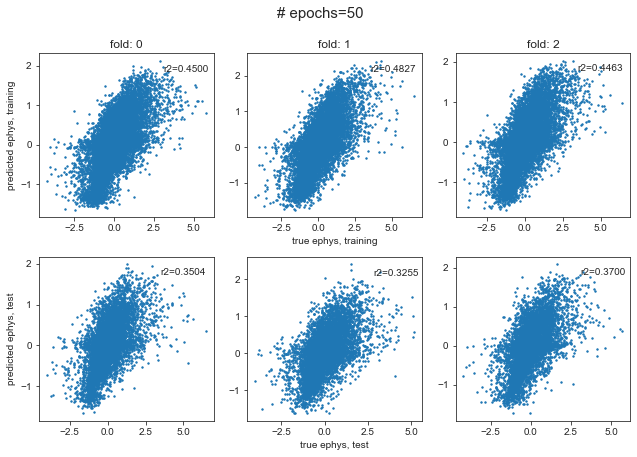

In [261]:
# First visualisation of the data.
fig, axes = plt.subplots(2, folds, figsize=(9, 2*folds))
for i in range(folds):
    axes[0, i].scatter(train_ephys[i], train_ephys_predict[i], s=2)
    axes[0, i].annotate('r2={:.4f}'.format(r2_straight_regr_tr[i, 0, 0]), \
                    xy=(0.5*axes[0, i].get_xlim()[1], 0.8*axes[0, i].get_ylim()[1]))
    axes[0, i].set_title('fold: {}'.format(i))
    axes[1, i].scatter(test_ephys[i], test_ephys_predict[i], s=2)
    axes[1, i].annotate('r2={:.4f}'.format(r2_straight_regr[i, 0, 0]), \
                    xy=(0.5*axes[1, i].get_xlim()[1], 0.8*axes[1, i].get_ylim()[1]))
axes[0, 1].set_xlabel('true ephys, training')
axes[0, 0].set_ylabel('predicted ephys, training')
axes[1, 1].set_xlabel('true ephys, test')
axes[1, 0].set_ylabel('predicted ephys, test')
fig.suptitle('# epochs={}'.format(epochs), fontsize=15, y=1.05)
plt.tight_layout()

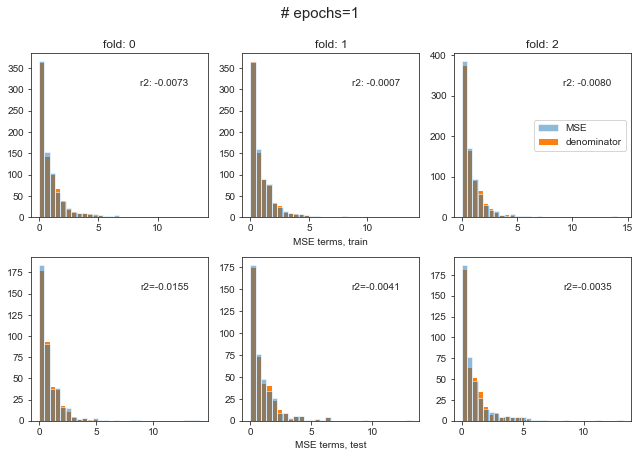

In [228]:
fig, axes = plt.subplots(2, folds, figsize=(9, 2*folds))
for i in range(folds):
    axes[0, i].hist((train_ephys[i]-train_ephys_predict[i])[:, 0]**2, bins=30, alpha=0.5, zorder=1, label='MSE')
    axes[0, i].hist(train_ephys[i][:, 0]**2, bins=30, zorder=0, label='denominator')
    axes[0, i].annotate('r2: {:.4f}'.format(r2_straight_regr_tr[i, 0, 0]), \
                        xy=(0.6*axes[0, i].get_xlim()[1], 0.8*axes[0, i].get_ylim()[1]))
    axes[0, i].set_title('fold: {}'.format(i))
    axes[1, i].hist((test_ephys[i]-test_ephys_predict[i])[:, 0]**2, bins=30, alpha=0.5, zorder=1, label='MSE')
    axes[1, i].hist(test_ephys[i][:, 0]**2, bins=30, zorder=0, label='denominator')
    axes[1, i].annotate('r2={:.4f}'.format(r2_straight_regr[i, 0, 0]), \
                        xy=(0.6*axes[1, i].get_xlim()[1], 0.8*axes[1, i].get_ylim()[1]))
fig.suptitle('# epochs={}'.format(epochs), fontsize=15, y=1.05)
axes[0, 2].legend(loc='right')
axes[0, 1].set_xlabel('MSE terms, train')
axes[1, 1].set_xlabel('MSE terms, test')
plt.tight_layout()

In [178]:
with open('KerasSavedModels/Bottleneck_r2_straight_regr.pickle', 'wb') as f:
    pickle.dump([r2_straight_regr, r2_straight_regr_tr, \
                 r2_straight_regr_hist, r2_straight_regr_hist_tr], f)

Our ridge penalty only classification pre-training model.

In [208]:
importlib.reload(bottleneck_networks)

<module 'bottleneck_networks' from '/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/bottleneck_revision/bottleneck_networks.py'>

In [209]:
from bottleneck_networks import ClassificationPreTrain

In [210]:
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([0])

act='elu'
folds=10
seed=42
lr=0.0001
epochs=50
bs=32
patience=epochs


t = time.time()
np.random.seed(seed)
n = X_no_low_qual.shape[0]
ind = np.random.permutation(n)
X = X_no_low_qual[ind,:]
Y = Y_no_low_qual[ind,:]
clusters_ = clusters[ind]
ind_pre_train = ind_pre_training_clusters[ind]

CE_loss = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
CE_loss_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
pre_tr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))
pre_tr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    clusters_train = np.copy(clusters_[indtrain])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    clusters_test = np.copy(clusters_[indtest])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean

    # In our training set we now look for a 'pretraining' training and test data set that we can use
    # for pretraing a classification network, i.e. picking the best model will be done with a seperate val set in our
    # training set for regression.

    x_train_pre_tr = x_train[ind_pre_train[indtrain], :]
    clusters_train_pre_tr = clusters_train[ind_pre_train[indtrain]]
    
    pre_train_size = 0.6
    train_cnt = round(x_train_pre_tr.shape[0]*pre_train_size)
    x_train_pre_tr_ = x_train_pre_tr[:train_cnt, :]
    x_test_pre_tr_ = x_train_pre_tr[train_cnt:, :]
    clusters_train_pre_tr_ = clusters_train_pre_tr[:train_cnt]
    clusters_test_pre_tr_ = clusters_train_pre_tr[train_cnt:]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)


            input_dim = x_train.shape[1]
            output_dim = to_categorical(clusters_train_pre_tr).shape[1]
            BN_Classification = ClassificationPreTrain(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, \
                                                       output_dim=output_dim)
            CE_train, CE_test, train_hist, test_hist = BN_Classification.train(x_train=x_train_pre_tr_, \
                                                                               cluster_train=clusters_train_pre_tr_, \
                                                                               x_test=x_test_pre_tr_, \
                                                                               cluster_test=clusters_test_pre_tr_, \
                                                                               epochs=epochs, bs=bs, patience=patience, \
                                                                               cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                               verbose=0)
            CE_loss[cvfold, j, i] = CE_test
            CE_loss_tr[cvfold, j, i] = CE_train
            pre_tr_hist[cvfold, j, i] = test_hist
            pre_tr_hist_tr[cvfold, j, i] = train_hist
            #print('Test CE loss (pre-trainin): ', CE_loss[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
437/437 [==============================] - 0s 103us/sample - loss: 2.2675 - categorical_crossentropy: 2.2675

CVFOLD:  1
[INFO] training network...
437/437 [==============================] - 0s 97us/sample - loss: 2.0944 - categorical_crossentropy: 2.0944

CVFOLD:  2
[INFO] training network...
437/437 [==============================] - 0s 95us/sample - loss: 2.0022 - categorical_crossentropy: 2.0022

CVFOLD:  3
[INFO] training network...
437/437 [==============================] - 0s 86us/sample - loss: 2.1123 - categorical_crossentropy: 2.1123

CVFOLD:  4
[INFO] training network...
437/437 [==============================] - 0s 102us/sample - loss: 1.9831 - categorical_crossentropy: 1.9831

CVFOLD:  5
[INFO] training network...
437/437 [==============================] - 0s 100us/sample - loss: 2.0537 - categorical_crossentropy: 2.0537

CVFOLD:  6
[INFO] training network...
437/437 [==============================] - 0s 99us/sample - loss: 2.0151 - c

In [211]:
with open('KerasSavedModels/Bottleneck_pre_tr.pickle', 'wb') as f:
    pickle.dump([CE_loss, CE_loss_tr, pre_tr_hist, pre_tr_hist_tr], f)

Our ridge penalty only pre-train and regression model.

In [212]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([0])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True

r2_pretr_straight_regr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))
r2_pretr_straight_regr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))

t = time.time()
np.random.seed(seed)
n = X_no_low_qual.shape[0]
ind = np.random.permutation(n)
X = X_no_low_qual[ind,:]
Y = Y_no_low_qual[ind,:]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            
            pre_trained_weights_h5 = 'KerasSavedModels/Classification_weights_{}_{}_{}.h5'.format(cvfold, j, i)
            
            BN_PreTrStraightRegression = StraightRegression(l1=l1, l2=l2, lr=lr, act=act, \
                                            input_dim=input_dim, output_dim=output_dim, \
                                            pre_trained_weights=pre_trained_weights, \
                                            pre_trained_weights_h5=pre_trained_weights_h5)
            _, _, r2_train, r2_test, train_hist, test_hist, _, _ = BN_PreTrStraightRegression.train(x_train=x_train, y_train=y_train, \
                                                                                   x_test=x_test, y_test=y_test, \
                                                                                   epochs=epochs, bs=bs, patience=patience, \
                                                                                   cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                                   verbose=0)
            r2_pretr_straight_regr[cvfold, j, i] = r2_test
            r2_pretr_straight_regr_tr[cvfold, j, i] = r2_train
            r2_pretr_straight_regr_hist[cvfold, j, i] = test_hist
            r2_pretr_straight_regr_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (regression, after pre-tr): ', r2_pretr_straight_regr[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
Train R^2:  0.41680288314819336
Test R^2:  0.40093010663986206

CVFOLD:  1
[INFO] training network...
Train R^2:  0.47565680742263794
Test R^2:  0.39666301012039185

CVFOLD:  2
[INFO] training network...
Train R^2:  0.5053433477878571
Test R^2:  0.3730907440185547

CVFOLD:  3
[INFO] training network...
Train R^2:  0.485640287399292
Test R^2:  0.337832510471344

CVFOLD:  4
[INFO] training network...
Train R^2:  0.5018410682678223
Test R^2:  0.36722874641418457

CVFOLD:  5
[INFO] training network...
Train R^2:  0.45443475246429443
Test R^2:  0.3464241623878479

CVFOLD:  6
[INFO] training network...
Train R^2:  0.5118473768234253
Test R^2:  0.3684956431388855

CVFOLD:  7
[INFO] training network...
Train R^2:  0.5512220859527588
Test R^2:  0.4070894122123718

CVFOLD:  8
[INFO] training network...
Train R^2:  0.45990467071533203
Test R^2:  0.3577401041984558

CVFOLD:  9
[INFO] training network...
Train R^2:  0.4802898168563843
Test R^2:  0.407301664352

In [213]:
with open('KerasSavedModels/Bottleneck_r2_pre_tr_and_straight_regr.pickle', 'wb') as f:
    pickle.dump([r2_pretr_straight_regr, r2_pretr_straight_regr_tr, \
                 r2_pretr_straight_regr_hist, r2_pretr_straight_regr_hist_tr], f)

Our ridge penalty only pre-train + freeze the first 2 layers + unfreeze model.

In [214]:
importlib.reload(bottleneck_networks)

<module 'bottleneck_networks' from '/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/bottleneck_revision/bottleneck_networks.py'>

In [215]:
from bottleneck_networks import FreezeUnfreeze

In [216]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([0])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
unfreeze = [False, False, True, True, True, True] # last 4 layers can be trained only first


r2_before_unfreezing = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_before_unfreezing_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_freeze_unfreeze_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 2*epochs))
r2_freeze_unfreeze_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 2*epochs))

t = time.time()
np.random.seed(seed)
n = X_no_low_qual.shape[0]
ind = np.random.permutation(n)
X = X_no_low_qual[ind,:]
Y = Y_no_low_qual[ind,:]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            
            pre_trained_weights_h5 = 'KerasSavedModels/Classification_weights_{}_{}_{}.h5'.format(cvfold, j, i)
            input_dim = x_train.shape[1]
            output_dim = y_train.shape[1]
            BN_PreTrFreezeUnfreeze = FreezeUnfreeze(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, output_dim=output_dim, \
                                                       unfreeze = unfreeze, \
                                                       pre_trained_weights=pre_trained_weights, \
                                                       pre_trained_weights_h5=pre_trained_weights_h5)
            r2_before_unfreezing_train, r2_before_unfreezing_test, \
                r2_after_unfreezing_train, r2_after_unfreezing_test, \
                train_hist, test_hist = BN_PreTrFreezeUnfreeze.train(x_train=x_train, y_train=y_train, \
                                                                    x_test=x_test, y_test=y_test, \
                                                                    epochs=epochs, bs=bs, patience=patience, \
                                                                    cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                    verbose=0)
            r2_before_unfreezing[cvfold, j, i] = r2_before_unfreezing_test
            r2_before_unfreezing_tr[cvfold, j, i] = r2_before_unfreezing_train
            r2_after_unfreezing[cvfold, j, i] = r2_after_unfreezing_test
            r2_after_unfreezing_tr[cvfold, j, i] = r2_after_unfreezing_train
            r2_freeze_unfreeze_hist[cvfold, j, i] = test_hist
            r2_freeze_unfreeze_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (before unfreezing): ', r2_before_unfreezing[cvfold, j, i])
            #print('Test R^2 score (after unfreezing): ', r2_after_unfreezing[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
[INFO] training network...
Train R^2 before unfreezing:  0.3746224045753479
Test R^2 before unfreezing:  0.3628969192504883
Train R^2 after unfreezing:  0.5203922390937805
Test R^2 after unfreezing:  0.3988357186317444

CVFOLD:  1
[INFO] training network...
[INFO] training network...
Train R^2 before unfreezing:  0.4021979570388794
Test R^2 before unfreezing:  0.3649265170097351
Train R^2 after unfreezing:  0.48689401149749756
Test R^2 after unfreezing:  0.3881579041481018

CVFOLD:  2
[INFO] training network...
[INFO] training network...
Train R^2 before unfreezing:  0.42349886894226074
Test R^2 before unfreezing:  0.3658245801925659
Train R^2 after unfreezing:  0.47602951526641846
Test R^2 after unfreezing:  0.3794192671775818

CVFOLD:  3
[INFO] training network...
[INFO] training network...
Train R^2 before unfreezing:  0.3971576690673828
Test R^2 before unfreezing:  0.36275553703308105
Train R^2 after unfreezing:  0.4749484062194824
Test R^2 af

In [217]:
with open('KerasSavedModels/Bottleneck_r2_pre_tr_and_freeze_unfreeze.pickle', 'wb') as f:
    pickle.dump([r2_before_unfreezing, r2_before_unfreezing_tr, \
                 r2_after_unfreezing, r2_after_unfreezing_tr, \
                 r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr], f)

In the next section we perform reduced-rank regression cross validation (rank = 2 and full rank).

In [100]:
# CV sRRR rank = 2

lambdas = np.concatenate([np.arange(.1,2,.1), np.arange(2,8)])
alphas = np.array([0])

rank = 2
folds = 10
seed = 42

r2_sRRR_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_rank2_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank2_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
nonzero_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
corrs_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))
corrs_relaxed_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))

# Uncomment if one lambda only
train_ephys = []
test_ephys = []
train_ephys_predict = []
test_ephys_predict = []

t = time.time()

np.random.seed(seed)
n = X_no_low_qual.shape[0]
ind = np.random.permutation(n)
X = X_no_low_qual[ind,:]
Y = Y_no_low_qual[ind,:]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    x_train = x_train.astype('float64')
    y_train = y_train.astype('float64')
    x_test = x_test.astype('float64')
    y_test = y_test.astype('float64')
    
    train_ephys.append(y_train)
    test_ephys.append(y_test)
    for i,a in enumerate(lambdas):
        #print('Lambdau: ', a)
        for j, b in enumerate(alphas):
            #print('Alpha: ', b)
            vx,vy = sparseRRR.elastic_rrr(x_train, y_train, lambdau=a, alpha=b, rank=rank, sparsity='row-wise')

            nz = np.sum(np.abs(vx), axis=1) != 0
            if np.sum(nz) < rank:
                nonzero_rank2[cvfold, j, i] = np.nan
                continue

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank2[cvfold, j, i] = np.nan
                continue

            nonzero_rank2[cvfold, j, i] = np.sum(nz)
            r2_sRRR_rank2[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum((y_test-np.mean(y_test))**2)
            r2_sRRR_rank2_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum((y_train-np.mean(y_train, axis=0))**2)
            for r in range(rank):
                corrs_rank2[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]

            # Relaxation
            vx[nz,:],vy = sparseRRR.elastic_rrr(x_train[:,nz], y_train, lambdau=a, alpha=0, rank=rank, sparsity='row-wise')

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank2[cvfold, j, i] = np.nan
                continue

            r2_sRRR_relaxed_rank2[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum((y_test-np.mean(y_test))**2)
            r2_sRRR_relaxed_rank2_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum((y_train-np.mean(y_train, axis=0))**2)
            for r in range(rank):
                corrs_relaxed_rank2[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]
            
            train_ephys_predict.append(x_train@vx@vy.T)
            test_ephys_predict.append(x_test@vx@vy.T)
            #print(r2_sRRR_relaxed_rank2[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0

CVFOLD:  1

CVFOLD:  2

CVFOLD:  3

CVFOLD:  4

CVFOLD:  5

CVFOLD:  6

CVFOLD:  7

CVFOLD:  8

CVFOLD:  9
Time: 0.0h  5m 15s


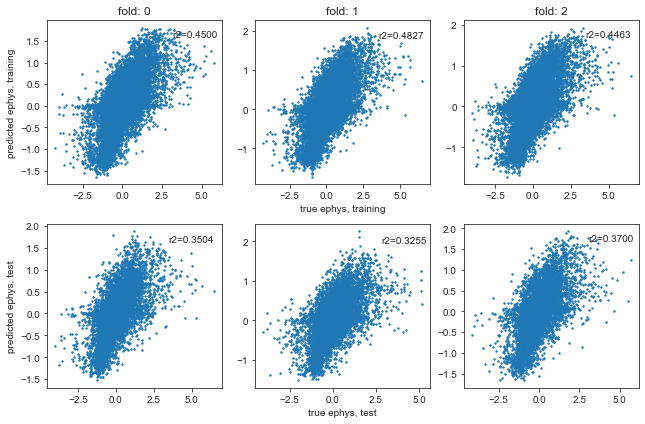

In [265]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for i in range(folds):
    axes[0, i].scatter(train_ephys[i], train_ephys_predict[i], s=2)
    axes[0, i].annotate('r2={:.4f}'.format(r2_straight_regr_tr[i, 0, 0]), \
                    xy=(0.5*axes[0, i].get_xlim()[1], 0.8*axes[0, i].get_ylim()[1]))
    axes[0, i].set_title('fold: {}'.format(i))
    axes[1, i].scatter(test_ephys[i], test_ephys_predict[i], s=2)
    axes[1, i].annotate('r2={:.4f}'.format(r2_straight_regr[i, 0, 0]), \
                    xy=(0.5*axes[1, i].get_xlim()[1], 0.8*axes[1, i].get_ylim()[1]))
axes[0, 1].set_xlabel('true ephys, training')
axes[0, 0].set_ylabel('predicted ephys, training')
axes[1, 1].set_xlabel('true ephys, test')
axes[1, 0].set_ylabel('predicted ephys, test')
#fig.suptitle('# epochs={}'.format(epochs), fontsize=15, y=1.05)
plt.tight_layout()
#plt.savefig('figures/larger_bottleneck_epoch_{}'.format(epochs))

In [101]:
with open('KerasSavedModels/sRRR_vs_Bottleneck_rank2_CV.pickle', 'wb') as f:
    pickle.dump([r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2], f)

In [80]:
# CV sRRR full rank

lambdas = np.concatenate([np.arange(.1,2,.1), np.arange(2,8)])
alphas = np.array([0])

rank = Y_no_low_qual.shape[1]
folds = 10
seed = 42

r2_sRRR_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_rank16_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank16_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
nonzero_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
corrs_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))
corrs_relaxed_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))


t = time.time()

np.random.seed(seed)
n = X_no_low_qual.shape[0]
ind = np.random.permutation(n)
X = X_no_low_qual[ind,:]
Y = Y_no_low_qual[ind,:]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    x_train = x_train.astype('float64')
    y_train = y_train.astype('float64')
    x_test = x_test.astype('float64')
    y_test = y_test.astype('float64')
    
    for i,a in enumerate(lambdas):
        #print('Labmdau: ', a)
        for j, b in enumerate(alphas):
            #print('Alpha: ', b)
            vx,vy = sparseRRR.elastic_rrr(x_train, y_train, lambdau=a, alpha=b, rank=rank, sparsity='row-wise')

            nz = np.sum(np.abs(vx), axis=1) != 0
            if np.sum(nz) < rank:
                nonzero_rank16[cvfold, j, i] = np.nan
                continue

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank16[cvfold, j, i] = np.nan
                continue

            nonzero_rank16[cvfold, j, i] = np.sum(nz)
            r2_sRRR_rank16[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum((y_test-np.mean(y_test))**2)
            r2_sRRR_rank16_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum((y_train-np.mean(y_train, axis=0))**2)
            for r in range(rank):
                corrs_rank16[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]

            # Relaxation
            vx[nz,:],vy = sparseRRR.elastic_rrr(x_train[:,nz], y_train, lambdau=a, alpha=0, rank=rank, sparsity='row-wise')

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank16[cvfold, j, i] = np.nan
                continue

            r2_sRRR_relaxed_rank16[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum((y_test-np.mean(y_test))**2)
            r2_sRRR_relaxed_rank16_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum((y_train-np.mean(y_train, axis=0))**2)
            for r in range(rank):
                corrs_relaxed_rank16[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]
            #print(r2_sRRR_relaxed_rank16_tr[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0

CVFOLD:  1

CVFOLD:  2

CVFOLD:  3

CVFOLD:  4

CVFOLD:  5

CVFOLD:  6

CVFOLD:  7

CVFOLD:  8

CVFOLD:  9
Time: 0.0h  5m 26s


In [81]:
with open('KerasSavedModels/sRRR_vs_Bottleneck_rank16_CV.pickle', 'wb') as f:
    pickle.dump([r2_sRRR_rank16, r2_sRRR_relaxed_rank16, r2_sRRR_rank16_tr, r2_sRRR_relaxed_rank16_tr, \
                nonzero_rank16, corrs_rank16, corrs_relaxed_rank16], f)

We now have cross validated results for all the ridge penalty models we care about. Let us now analyse and compare the training curves. 

In [131]:
lambdas = np.concatenate([np.arange(.1,2,.1), np.arange(2,10)])

In [132]:
with open('KerasSavedModels/sRRR_vs_Bottleneck_rank2_CV.pickle', 'rb') as f:
    r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2 = pickle.load(f)

In [133]:
with open('KerasSavedModels/sRRR_vs_Bottleneck_rank16_CV.pickle', 'rb') as f:
    r2_sRRR_rank16, r2_sRRR_relaxed_rank16, r2_sRRR_rank16_tr, r2_sRRR_relaxed_rank16_tr, \
                nonzero_rank16, corrs_rank16, corrs_relaxed_rank16 = pickle.load(f)

In [134]:
with open('KerasSavedModels/Bottleneck_pre_tr.pickle', 'rb') as f:
    CE_loss, CE_loss_tr, pre_tr_hist, pre_tr_hist_tr = pickle.load(f)

In [135]:
with open('KerasSavedModels/Bottleneck_r2_straight_regr.pickle', 'rb') as f:
    r2_straight_regr, r2_straight_regr_tr, \
                 r2_straight_regr_hist, r2_straight_regr_hist_tr = pickle.load(f)

In [136]:
with open('KerasSavedModels/Bottleneck_r2_pre_tr_and_straight_regr.pickle', 'rb') as f:
    r2_pretr_straight_regr, r2_pretr_straight_regr_tr, \
                 r2_pretr_straight_regr_hist, r2_pretr_straight_regr_hist_tr = pickle.load(f)

In [137]:
with open('KerasSavedModels/Bottleneck_r2_pre_tr_and_freeze_unfreeze.pickle', 'rb') as f:
    r2_before_unfreezing, r2_before_unfreezing_tr, \
                 r2_after_unfreezing, r2_after_unfreezing_tr, \
                 r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr = pickle.load(f)

In [143]:
np.max(np.mean(r2_sRRR_relaxed_rank2, axis=0))

0.3732361939537469

In [144]:
np.max(np.mean(r2_sRRR_relaxed_rank16, axis=0))

0.45034916657942653

In [145]:
np.mean(r2_straight_regr)

0.3635542690753937

In [146]:
np.mean(r2_pretr_straight_regr)

0.3762796103954315

In [147]:
np.mean(r2_before_unfreezing)

0.3722318172454834

In [148]:
np.mean(r2_after_unfreezing)

0.39848690629005434

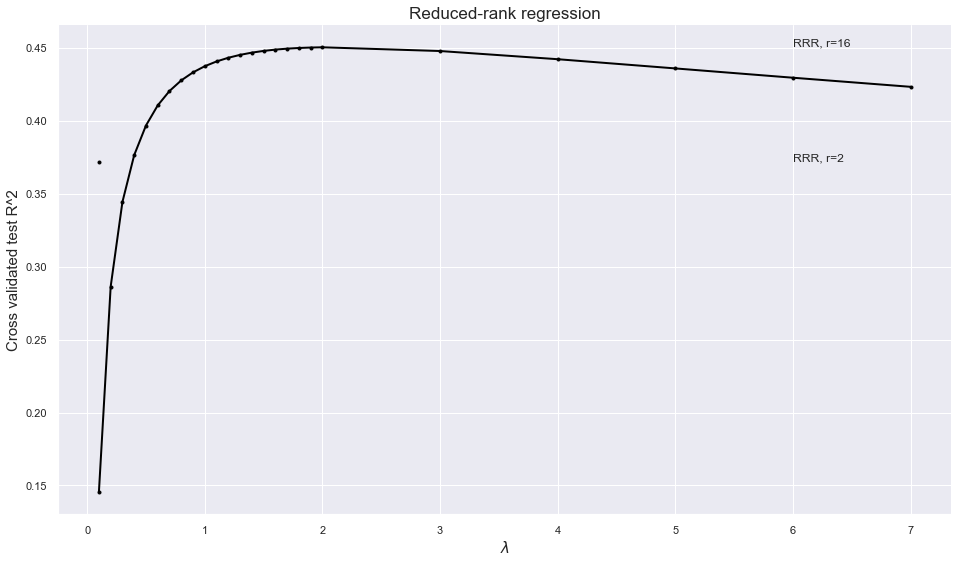

In [96]:
linewidth = 2

fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(111)

r2_sRRR_relaxed_rank2[r2_sRRR_relaxed_rank2==0]=np.nan
r2_sRRR_relaxed_rank2_ =  np.nanmean(r2_sRRR_relaxed_rank2, axis = 0)
r2_sRRR_relaxed_rank16[r2_sRRR_relaxed_rank16==0]=np.nan
r2_sRRR_relaxed_rank16_ =  np.nanmean(r2_sRRR_relaxed_rank16, axis = 0)

ax.plot(lambdas[np.nonzero(r2_sRRR_relaxed_rank16_[0, :])], \
             r2_sRRR_relaxed_rank16_[0, :][np.nonzero(r2_sRRR_relaxed_rank16_[0, :])], '.-', \
             c = np.array([0, 0, 0]) / 256, linewidth = linewidth, \
             label = 'r=16')
ax.plot(lambdas[np.nonzero(r2_sRRR_relaxed_rank2_[0, :])], \
             r2_sRRR_relaxed_rank2_[0, :][np.nonzero(r2_sRRR_relaxed_rank2_[0, :])], '.-', \
             c = np.array([0, 0, 0])/256, linewidth = linewidth, \
             label = 'r=2')
ax.annotate('RRR, r=16', (6, np.max(r2_sRRR_relaxed_rank16_)+0.0005))
ax.annotate('RRR, r=2', (6, np.max(r2_sRRR_relaxed_rank2_)+0.0005))
#ax.legend(loc = 'lower right', fontsize = 11)
ax.set_xlabel(r'$\lambda$', fontsize = 15)
ax.set_ylabel('Cross validated test R^2', fontsize = 15)
ax.set_title('Reduced-rank regression', fontsize = 17)
ax.tick_params(axis='both', which='major', labelsize=11, length=8)
ax.tick_params(axis='both', which='minor', labelsize=11, length=8)
#ax.set_xticks(list(range(8)))
sns.despine()

#plt.savefig('figures/RRR_cvcurves.png', dpi=200)

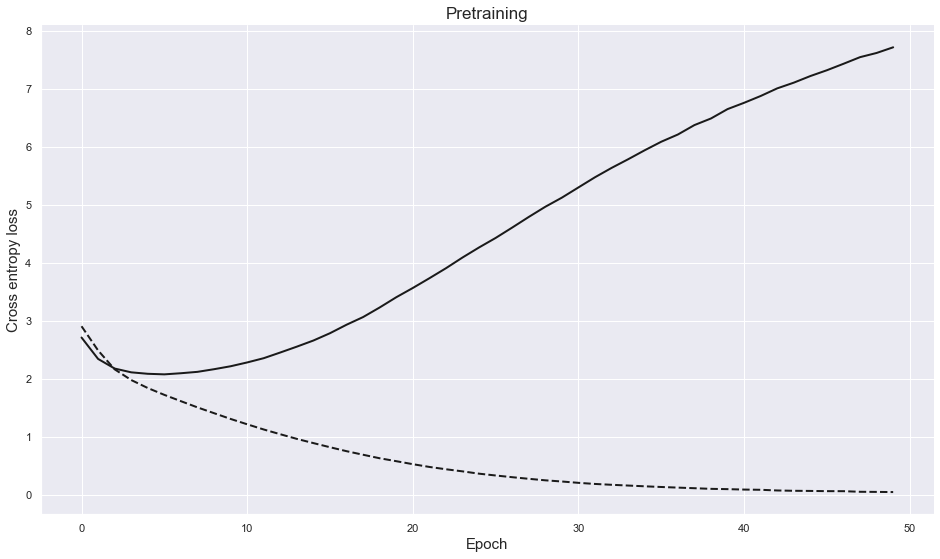

In [97]:
linewidth=2
fig = plt.figure(figsize = (16, 9))

ax = fig.add_subplot(111)
ax.plot(range(50), np.mean(pre_tr_hist_tr, axis=(0, 1, 2)), \
         '--', c = 'k', linewidth=linewidth)
ax.plot(range(50), np.mean(pre_tr_hist, axis=(0, 1, 2)), \
         c = 'k', linewidth=linewidth)
ax.set_title('Pretraining', fontsize = 17)
ax.set_xlabel('Epoch', fontsize = 15)
ax.set_ylabel('Cross entropy loss', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.tick_params(axis='both', which='minor', labelsize=11)
sns.despine()

#plt.savefig('figures/Bottleneck_Learning_Curves_Pretraining.png', dpi = 200)

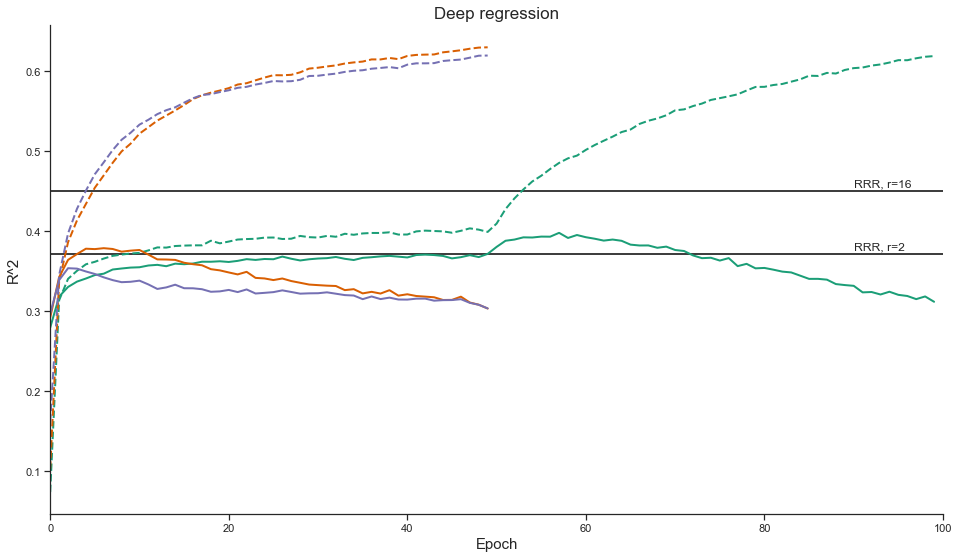

In [98]:
linewidth=2
sns_styleset()
fig = plt.figure(figsize = (16, 9))

r2_sRRR_relaxed_rank2_ = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)
r2_sRRR_relaxed_rank16_ = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)

ax = fig.add_subplot(111)
ax.plot(range(100), np.mean(r2_freeze_unfreeze_hist_tr, axis=(0, 1, 2)), \
         '--', c = '#1b9e77', linewidth=linewidth)
ax.plot(range(100), np.mean(r2_freeze_unfreeze_hist, axis=(0, 1, 2)), \
         c = '#1b9e77', linewidth=linewidth)
ax.plot(range(50), np.mean(r2_pretr_straight_regr_hist_tr, axis=(0, 1, 2)), \
         '--', c = '#d95f02', linewidth=linewidth)
ax.plot(range(50), np.mean(r2_pretr_straight_regr_hist, axis=(0, 1, 2)), \
         c = '#d95f02', linewidth=linewidth)
ax.plot(range(50), np.mean(r2_straight_regr_hist_tr, axis=(0, 1, 2)), \
         '--', c = '#7570b3', linewidth=linewidth)
ax.plot(range(50), np.mean(r2_straight_regr_hist, axis=(0, 1, 2)), \
         c = '#7570b3', linewidth=linewidth)
# ax.hlines(np.max(r2_sRRR_relaxed_rank2_), xmin = 0, xmax = 120, \
#            colors = np.array([105,105,105])/256, label = 'RRR, r=2')
ax.hlines(np.max(r2_sRRR_relaxed_rank2_), xmin = 0, xmax = 120, \
            colors = np.array([0,0,0])/256)
ax.annotate('RRR, r=2', (90, np.max(r2_sRRR_relaxed_rank2_)+0.005))
ax.hlines(np.max(r2_sRRR_relaxed_rank16_), xmin = 0, xmax = 120, \
           colors = np.array([0,0,0])/256)
ax.annotate('RRR, r=16', (90, np.max(r2_sRRR_relaxed_rank16_)+0.005))
#ax.set_ylim([0,0.7])
ax.set_xlim([0,100])
ax.set_title('Deep regression', fontsize = 17)
ax.set_xlabel('Epoch', fontsize = 15)
ax.set_ylabel('R^2', fontsize = 15)
#ax.legend(loc='lower right', fontsize = 11)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.tick_params(axis='both', which='minor', labelsize=11)
sns.despine()

#plt.savefig('figures/Bottleneck_Learning_Curves.png', dpi = 200)

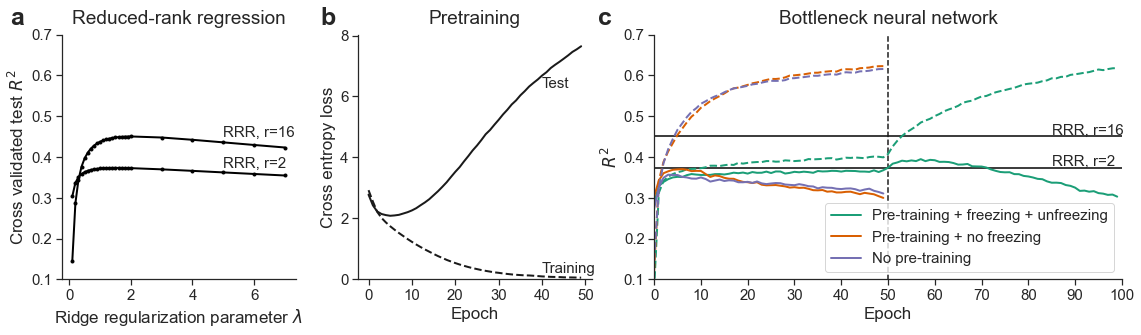

In [219]:
linewidth = 2
sns_styleset()

r2_sRRR_relaxed_rank2[r2_sRRR_relaxed_rank2==0]=np.nan
r2_sRRR_relaxed_rank2_ =  np.nanmean(r2_sRRR_relaxed_rank2, axis = 0)
r2_sRRR_relaxed_rank16[r2_sRRR_relaxed_rank16==0]=np.nan
r2_sRRR_relaxed_rank16_ =  np.nanmean(r2_sRRR_relaxed_rank16, axis = 0)


# All together in one plot for the paper
fig = plt.figure(figsize=(19, 4.5))
widths = [1, 1, 2]
heights = [1]
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths,
                          height_ratios=heights)
ax1 = fig.add_subplot(spec[0, 0])
ax1.plot(lambdas[np.nonzero(r2_sRRR_relaxed_rank16_[0, :])], \
             r2_sRRR_relaxed_rank16_[0, :][np.nonzero(r2_sRRR_relaxed_rank16_[0, :])], '.-', \
             c = np.array([0, 0, 0]) / 256, linewidth = linewidth, \
             label = 'r=16')
ax1.plot(lambdas[np.nonzero(r2_sRRR_relaxed_rank2_[0, :])], \
             r2_sRRR_relaxed_rank2_[0, :][np.nonzero(r2_sRRR_relaxed_rank2_[0, :])], '.-', \
             c = np.array([0, 0, 0])/256, linewidth = linewidth, \
             label = 'r=2')
ax1.annotate('RRR, r=16', (5, np.max(r2_sRRR_relaxed_rank16_)+0.0002), fontsize=15)
ax1.annotate('RRR, r=2', (5, np.max(r2_sRRR_relaxed_rank2_)+0.0002), fontsize=15)
ax1.set_xlabel(r'Ridge regularization parameter $\lambda$', fontsize = 17)
ax1.set_ylabel(r'Cross validated test $R^2$', fontsize = 17)
ax1.set_title('Reduced-rank regression', fontsize = 19, y=1.02)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax1.set_ylim([0.1,0.7])

ax2 = fig.add_subplot(spec[0, 1])
ax2.plot(range(50), np.mean(pre_tr_hist_tr, axis=(0, 1, 2)), \
         '--', c = 'k', linewidth=linewidth)
ax2.plot(range(50), np.mean(pre_tr_hist, axis=(0, 1, 2)), \
         c = 'k', linewidth=linewidth)
ax2.set_title('Pretraining', fontsize = 19, y=1.02)
ax2.set_xlabel('Epoch', fontsize = 17)
ax2.set_ylabel('Cross entropy loss', fontsize = 17)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='minor', labelsize=15)
ax2.set_ylim([0, ax2.get_ylim()[1]])
ax2.annotate('Training', (40, 0.22), fontsize=15)
ax2.annotate('Test', (40, 6.3), fontsize=15)
ax2.set_xticks(np.arange(0, 60, 10))

ax3 = fig.add_subplot(spec[0, 2])
ax3.plot(range(100), np.mean(r2_freeze_unfreeze_hist_tr, axis=(0, 1, 2)), \
         '--', c = '#1b9e77', linewidth=linewidth)
ax3.plot(range(100), np.mean(r2_freeze_unfreeze_hist, axis=(0, 1, 2)), \
         c = '#1b9e77', linewidth=linewidth, label='Pre-training + freezing + unfreezing')
ax3.plot(range(50), np.mean(r2_pretr_straight_regr_hist_tr, axis=(0, 1, 2)), \
         '--', c = '#d95f02', linewidth=linewidth)
ax3.plot(range(50), np.mean(r2_pretr_straight_regr_hist, axis=(0, 1, 2)), \
         c = '#d95f02', linewidth=linewidth, label='Pre-training + no freezing')
ax3.plot(range(50), np.mean(r2_straight_regr_hist_tr, axis=(0, 1, 2)), \
         '--', c = '#7570b3', linewidth=linewidth)
ax3.plot(range(50), np.mean(r2_straight_regr_hist, axis=(0, 1, 2)), \
         c = '#7570b3', linewidth=linewidth, label='No pre-training')
ax3.hlines(np.max(r2_sRRR_relaxed_rank2_), xmin = 0, xmax = 120, \
            colors = np.array([0,0,0])/256)
ax3.annotate('RRR, r=2', (85, np.max(r2_sRRR_relaxed_rank2_)+0.005), fontsize=15)
ax3.hlines(np.max(r2_sRRR_relaxed_rank16_), xmin = 0, xmax = 120, \
           colors = np.array([0,0,0])/256)
ax3.annotate('RRR, r=16', (85, np.max(r2_sRRR_relaxed_rank16_)+0.005), fontsize=15)
ax3.legend(loc = 'lower right', fontsize=15)
ax3.set_ylim([0.1,0.7])
ax3.set_xlim([0,100])
ax3.set_title('Bottleneck neural network', fontsize = 19, y=1.02)
ax3.set_xlabel('Epoch', fontsize = 17)
ax3.set_ylabel(r'$R^2$', fontsize = 17)
ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.tick_params(axis='both', which='minor', labelsize=15)
ax3.set_xticks(np.arange(0, 110, 10))
ax3.vlines(50, ymin=0, ymax=ax3.get_ylim()[1], linestyle='dashed')

plt.text(-0.22, 1.04, 'a', transform = ax1.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.16, 1.04, 'b', transform = ax2.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.12, 1.04, 'c', transform = ax3.transAxes, fontsize=25, fontweight='bold')
sns.despine()
plt.savefig('figures/Ridge_training_curves.pdf', bbox_inches = 'tight',
    pad_inches = 0)
plt.savefig('figures/Ridge_training_curves.png', bbox_inches = 'tight',
    pad_inches = 0)

# Add lasso

It seems that pre-train - train 4 last layers - train all layers is a good bottleneck non-linear model. Let us add a lasso group penalty now and investigate which genes the model would select. After the usual training as above we also prune the bottleneck further. In essence we pick the 25 genes that correspond to highest L2 row norm for the first kernel/weight of the input layer and perform the same regression task but with this reduced new 25 nodes input layer. No lasso, just ridge for this pruned network. We investigate which genes are selected, visualise the latent space and compare to a well-known sparse reduced-rank model for this dataset. Again, one can skip the training and go direct to visualization for already trained models.

Our ridge + lasso penalty straight regression (no pre-training) model.

In [92]:
importlib.reload(bottleneck_networks)

<module 'bottleneck_networks' from '/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/bottleneck_revision/bottleneck_networks.py'>

In [93]:
from bottleneck_networks import StraightRegression

In [96]:
# Settings
l2_params = np.logspace(-12, -4, num=5)
l1_params = np.array([1e-1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
prune=True
patience=epochs

r2_straight_regr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_ap = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_ap_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_straight_regr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = X_no_low_qual.shape[0]
ind = np.random.permutation(n)
X = X_no_low_qual[ind,:]
Y = Y_no_low_qual[ind,:]

nodes_list=[512,128,2,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            BN_StraightRegression = StraightRegression(l1=l1, l2=l2, lr=lr, act=act, \
                                                       input_dim=input_dim, output_dim=output_dim, nodes_list=nodes_list)
            r2_train, r2_test, \
                r2_ap_train, r2_ap_test, \
                train_hist, test_hist = BN_StraightRegression.train(x_train=x_train, y_train=y_train, \
                                                                                   x_test=x_test, y_test=y_test, \
                                                                                   epochs=epochs, bs=bs, patience=patience, \
                                                                                   cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                                   prune=prune, geneNames=geneNames, \
                                                                                   verbose=0)
            r2_straight_regr[cvfold, j, i] = r2_test
            r2_straight_regr_tr[cvfold, j, i] = r2_train
            r2_straight_regr_ap[cvfold, j, i] = r2_ap_test
            r2_straight_regr_ap_tr[cvfold, j, i] = r2_ap_train
            r2_straight_regr_hist[cvfold, j, i] = test_hist
            r2_straight_regr_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (straight regression, no pre-tr): ', r2_straight_regr[cvfold, j, i])
            #print('Test R^2 score after pruning (straight regression, no pre-tr): ', r2_straight_regr_ap[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
The 25 genes that make it:  ['Sema3c' 'Unc13c' 'Kcnc2' 'Gm43670' 'Grm1' 'Ighm' 'Enpp2' 'Mical2' 'Grm7'
 'Chl1' 'Lamp5' 'Cacna2d1' 'Ptk2b' 'Gabra1' 'Elfn1' 'Gm49948' 'Cplx1'
 'Ndn' 'Plch2' 'Sst' 'Atp1a3' 'Erbb4' 'Gad1' 'Tac2' 'Pvalb']
[INFO] training network...
Train R^2 before pruning:  0.42527079582214355
Test R^2 after pruning:  0.37346261739730835
Train R^2 after pruning:  0.40107065439224243
Test R^2 after pruning:  0.37039750814437866
[INFO] training network...
The 25 genes that make it:  ['Ighm' 'Nell1' 'Unc13c' 'Phactr1' 'Mical2' 'Chl1' 'Lingo2' 'Sparcl1'
 'Grm7' 'Ndn' 'Lamp5' 'Ptk2b' 'Cplx1' 'Gabra1' 'Gm49948' 'Elfn1'
 'Cacna2d1' 'Enpp2' 'Plch2' 'Atp1a3' 'Sst' 'Erbb4' 'Gad1' 'Tac2' 'Pvalb']
[INFO] training network...
Train R^2 before pruning:  0.41981858015060425
Test R^2 after pruning:  0.37615281343460083
Train R^2 after pruning:  0.4050772190093994
Test R^2 after pruning:  0.3713763952255249
[INFO] training network...
The 25 genes that 

In [97]:
with open('KerasSavedModels/Bottleneck_r2_straight_regr_lasso.pickle', 'wb') as f:
    pickle.dump([r2_straight_regr, r2_straight_regr_tr, \
                 r2_straight_regr_ap, r2_straight_regr_ap_tr, \
                 r2_straight_regr_hist, r2_straight_regr_hist_tr], f)

Our ridge + lasso penalty classification pre-training model.

In [98]:
from bottleneck_networks import ClassificationPreTrain

In [100]:
# Immediately for different penalties, but we'll be only interested in the 1e-1 penalty (for now), i.e. see extensions later
l2_params = np.logspace(-12, -4, num=5)
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs


t = time.time()
np.random.seed(seed)
n = X_no_low_qual.shape[0]
ind = np.random.permutation(n)
X = X_no_low_qual[ind,:]
Y = Y_no_low_qual[ind,:]
clusters_ = clusters[ind]
ind_pre_train = ind_pre_training_clusters[ind]

CE_loss = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
CE_loss_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
pre_tr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))
pre_tr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))

nodes_list=[512,128,2,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    clusters_train = np.copy(clusters_[indtrain])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    clusters_test = np.copy(clusters_[indtest])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean

    # In our training set we now look for a 'pretraining' training and test data set that we can use
    # for pretraing a classification network, i.e. picking the best model will be dones with a seperate val set in our
    # training set for regression.

    x_train_pre_tr = x_train[ind_pre_train[indtrain], :]
    clusters_train_pre_tr = clusters_train[ind_pre_train[indtrain]]
    
    pre_train_size = 0.6
    train_cnt = round(x_train_pre_tr.shape[0]*pre_train_size)
    x_train_pre_tr_ = x_train_pre_tr[:train_cnt, :]
    x_test_pre_tr_ = x_train_pre_tr[train_cnt:, :]
    clusters_train_pre_tr_ = clusters_train_pre_tr[:train_cnt]
    clusters_test_pre_tr_ = clusters_train_pre_tr[train_cnt:]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)


            input_dim = x_train.shape[1]
            output_dim = to_categorical(clusters_train_pre_tr).shape[1]
            BN_Classification = ClassificationPreTrain(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, \
                                                       output_dim=output_dim, nodes_list=nodes_list)
            CE_train, CE_test, train_hist, test_hist = BN_Classification.train(x_train=x_train_pre_tr_, \
                                                                               cluster_train=clusters_train_pre_tr_, \
                                                                               x_test=x_test_pre_tr_, \
                                                                               cluster_test=clusters_test_pre_tr_, \
                                                                               epochs=epochs, bs=bs, patience=patience, \
                                                                               cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                               verbose=0)
            CE_loss[cvfold, j, i] = CE_test
            CE_loss_tr[cvfold, j, i] = CE_train
            pre_tr_hist[cvfold, j, i] = test_hist
            pre_tr_hist_tr[cvfold, j, i] = train_hist
            #print('Test CE loss (pre-trainin): ', CE_loss[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
324/324 [==============================] - 0s 92us/sample - loss: 2.0397 - categorical_crossentropy: 1.9574
[INFO] training network...
324/324 [==============================] - 0s 105us/sample - loss: 9.1210 - categorical_crossentropy: 1.9465
[INFO] training network...
324/324 [==============================] - 0s 95us/sample - loss: 59.4002 - categorical_crossentropy: 2.0438
[INFO] training network...
324/324 [==============================] - 0s 109us/sample - loss: 125.6811 - categorical_crossentropy: 2.0373
[INFO] training network...
324/324 [==============================] - 0s 93us/sample - loss: 2.4295 - categorical_crossentropy: 2.3472
[INFO] training network...
324/324 [==============================] - 0s 101us/sample - loss: 9.2219 - categorical_crossentropy: 2.0517
[INFO] training network...
324/324 [==============================] - 0s 109us/sample - loss: 59.6122 - categorical_crossentropy: 2.0367
[INFO] training network...
324/324 

In [101]:
with open('KerasSavedModels/Bottleneck_pre_tr_lasso.pickle', 'wb') as f:
    pickle.dump([CE_loss, CE_loss_tr, pre_tr_hist, pre_tr_hist_tr], f)

Our lasso + ridge penalty pre-train and regression model.

In [102]:
# Settings
l2_params = np.logspace(-12, -4, num=5)
l1_params = np.array([1e-1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
prune=True

r2_pretr_straight_regr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_ap = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_ap_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_pretr_straight_regr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = X_no_low_qual.shape[0]
ind = np.random.permutation(n)
X = X_no_low_qual[ind,:]
Y = Y_no_low_qual[ind,:]

nodes_list=[512,128,2,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            
            pre_trained_weights_h5 = 'KerasSavedModels/Classification_last_weights_{}_{}_{}.h5'.format(cvfold, 2, i)
            
            BN_PreTrStraightRegression = StraightRegression(l1=l1, l2=l2, lr=lr, act=act, \
                                            input_dim=input_dim, output_dim=output_dim, \
                                            pre_trained_weights=pre_trained_weights, \
                                            pre_trained_weights_h5=pre_trained_weights_h5, nodes_list=nodes_list)
            r2_train, r2_test, \
                r2_train_ap, r2_test_ap, \
                train_hist, test_hist = BN_PreTrStraightRegression.train(x_train=x_train, y_train=y_train, \
                                                                                   x_test=x_test, y_test=y_test, \
                                                                                   epochs=epochs, bs=bs, patience=patience, \
                                                                                   cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                                   prune=prune, geneNames=geneNames, \
                                                                                   verbose=0)
            r2_pretr_straight_regr[cvfold, j, i] = r2_test
            r2_pretr_straight_regr_tr[cvfold, j, i] = r2_train
            r2_pretr_straight_regr_ap[cvfold, j, i] = r2_test_ap
            r2_pretr_straight_regr_ap_tr[cvfold, j, i] = r2_train_ap            
            r2_pretr_straight_regr_hist[cvfold, j, i] = test_hist
            r2_pretr_straight_regr_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (regression, after pre-tr): ', r2_pretr_straight_regr[cvfold, j, i])
            #print('Test R^2 score (regression, after pre-tr), after pruning: ', r2_pretr_straight_regr_ap[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
The 25 genes that make it:  ['Mas1' 'Phactr1' 'Mical2' 'Brinp1' 'Cacna2d1' 'Cplx1' 'Ighm' 'Enpp2'
 'Ptk2b' 'Gm11549' 'Chl1' 'Erbb4' 'Unc13c' 'Gabra1' 'Gm49948' 'Atp1a3'
 'Grm7' 'Elfn1' 'Ndn' 'Plch2' 'Gad1' 'Lamp5' 'Sst' 'Pvalb' 'Tac2']
[INFO] training network...
Train R^2 before pruning:  0.45872074365615845
Test R^2 after pruning:  0.4022189974784851
Train R^2 after pruning:  0.42096126079559326
Test R^2 after pruning:  0.3878968358039856
[INFO] training network...
The 25 genes that make it:  ['Mical2' 'Gm11549' 'Nell1' 'Galnt14' 'Brinp1' 'Ptk2b' 'Cacna2d1' 'Ighm'
 'Sparcl1' 'Ndn' 'Phactr1' 'Erbb4' 'Gm49948' 'Atp1a3' 'Gabra1' 'Elfn1'
 'Grm7' 'Enpp2' 'Unc13c' 'Plch2' 'Lamp5' 'Gad1' 'Tac2' 'Sst' 'Pvalb']
[INFO] training network...
Train R^2 before pruning:  0.4424235224723816
Test R^2 after pruning:  0.3979484438896179
Train R^2 after pruning:  0.4218037724494934
Test R^2 after pruning:  0.39039522409439087
[INFO] training network...
The 25 genes t

In [103]:
with open('KerasSavedModels/Bottleneck_r2_pre_tr_and_straight_regr_lasso.pickle', 'wb') as f:
    pickle.dump([r2_pretr_straight_regr, r2_pretr_straight_regr_tr, \
                 r2_pretr_straight_regr_ap, r2_pretr_straight_regr_ap_tr, \
                 r2_pretr_straight_regr_hist, r2_pretr_straight_regr_hist_tr], f)

Our lasso + ridge penalty pre-train + freeze the first 2 layers + unfreeze model.

In [104]:
from bottleneck_networks import FreezeUnfreeze

In [105]:
# Settings
l2_params = np.logspace(-12, -4, num=5)
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
unfreeze = [False, False, True, True, True, True] # last 4 layers can be trained only first
prune=True

r2_before_unfreezing = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_before_unfreezing_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_ap = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_ap_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_freeze_unfreeze_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_freeze_unfreeze_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = X_no_low_qual.shape[0]
ind = np.random.permutation(n)
X = X_no_low_qual[ind,:]
Y = Y_no_low_qual[ind,:]

nodes_list=[512,128,2,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            
            pre_trained_weights_h5 = 'KerasSavedModels/Classification_last_weights_{}_{}_{}.h5'.format(cvfold, j, i)
            input_dim = x_train.shape[1]
            output_dim = y_train.shape[1]
            BN_PreTrFreezeUnfreeze = FreezeUnfreeze(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, output_dim=output_dim, \
                                                       unfreeze = unfreeze, \
                                                       pre_trained_weights=pre_trained_weights, \
                                                       pre_trained_weights_h5=pre_trained_weights_h5, nodes_list=nodes_list)
            r2_before_unfreezing_train, r2_before_unfreezing_test, \
                r2_after_unfreezing_train, r2_after_unfreezing_test, \
                r2_after_unfreezing_train_ap, r2_after_unfreezing_test_ap, \
                train_hist, test_hist = BN_PreTrFreezeUnfreeze.train(x_train=x_train, y_train=y_train, \
                                                                    x_test=x_test, y_test=y_test, \
                                                                    epochs=epochs, bs=bs, patience=patience, \
                                                                    cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                    prune=prune, geneNames=geneNames, \
                                                                    verbose=0)
            r2_before_unfreezing[cvfold, j, i] = r2_before_unfreezing_test
            r2_before_unfreezing_tr[cvfold, j, i] = r2_before_unfreezing_train
            r2_after_unfreezing[cvfold, j, i] = r2_after_unfreezing_test
            r2_after_unfreezing_tr[cvfold, j, i] = r2_after_unfreezing_train
            r2_after_unfreezing_ap[cvfold, j, i] = r2_after_unfreezing_test_ap
            r2_after_unfreezing_ap_tr[cvfold, j, i] = r2_after_unfreezing_train_ap
            r2_freeze_unfreeze_hist[cvfold, j, i] = test_hist
            r2_freeze_unfreeze_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (before unfreezing): ', r2_before_unfreezing[cvfold, j, i])
            #print('Test R^2 score (after unfreezing): ', r2_after_unfreezing[cvfold, j, i])
            #print('Test R^2 score (after unfreezing and after pruning): ', r2_after_unfreezing_ap[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Zfp52' 'Atp1b2' 'Map1b' 'Arhgef6' 'Gabra4' 'Mlip' 'Prox1' 'Pcp4l1'
 'Oxr1' 'Rgs2' 'Rasgef1b' 'Paics' 'Pamr1' 'Armh4' 'Sh3bgrl' 'Calm2'
 'Caln1' 'Tnfrsf1b' 'Zfp941' 'Pdyn' 'Gpc3' 'Ranbp6' 'Edn1' 'Msmo1'
 'Gm49948']
[INFO] training network...
Train R^2 before unfreezing:  0.44387316703796387
Test R^2 before unfreezing:  0.36199676990509033
Train R^2 after unfreezing:  0.5220026075839996
Test R^2 after unfreezing:  0.36865007877349854
Train R^2 after unfreezing and pruning:  0.3400574326515198
Test R^2 after unfreezing and pruning:  0.2922728657722473
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Elmo1' 'Ndn' 'Cd81' 'Pfkp' 'Rasgef1b' 'Sh3bgrl' 'Tmem63a' 'Msmo1'
 'Kcnip3' 'Lhx6' 'Lgi1' 'Spon1' 'Nrp1' 'Vstm2a' 'Synpr' 'Enpp2' 'Sst'
 'Nxph1' 'Adcyap1' 'Crh' 'Pamr1' 'Sparcl1' 'Lamp5' 'Erbb4' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0.4573

[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Plcxd3' 'Pamr1' 'Nxph1' 'Coro6' 'Erbb4' 'Gad1' 'Tnnt1' 'Gm11549' 'Gad2'
 'Egfr' 'Calm2' 'Efemp1' 'Adarb2' 'Thsd7a' 'Pdyn' 'Serinc1' 'Prox1'
 'Gm48745' 'Kcnab3' 'Pvalb' 'Afap1' 'Lamp5' 'Cplx3' 'Npy' 'Ptk2b']
[INFO] training network...
Train R^2 before unfreezing:  0.43745625019073486
Test R^2 before unfreezing:  0.3419639468193054
Train R^2 after unfreezing:  0.5320859253406525
Test R^2 after unfreezing:  0.3637089133262634
Train R^2 after unfreezing and pruning:  0.4116174578666687
Test R^2 after unfreezing and pruning:  0.36253517866134644
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Grm7' 'Kcnip2' '6330403K07Rik' 'Ptk2b' 'Plch2' 'Coro6' 'Phactr1' 'Gad1'
 'Pcp4l1' 'Atp1a3' 'Thsd7a' 'Gm49948' 'Mical2' 'Synpr' 'Enpp2' 'Ndn' 'Sst'
 'Sparcl1' 'Elfn1' 'Lamp5' 'Cplx1' 'Tac2' 'Erbb4' 'Pvalb' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0.38275319337844

[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Cplx1' 'Gm49948' 'Kcnip2' 'Afap1' 'Ndst3' 'Nell2' 'Fxyd6' 'Arpp19'
 'Pde1a' 'Plch2' 'Grip1' 'Elfn1' 'Coro6' 'Magel2' 'Bdnf' 'Cacna1e' 'Tac2'
 'Unc13c' 'Lamp5' 'Gad1' 'Ndn' 'Htr3a' 'Sst' 'Pvalb' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0.37988853454589844
Test R^2 before unfreezing:  0.33415478467941284
Train R^2 after unfreezing:  0.4496447443962097
Test R^2 after unfreezing:  0.3907201290130615
Train R^2 after unfreezing and pruning:  0.4394906163215637
Test R^2 after unfreezing and pruning:  0.38129711151123047
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Tcp11l2' 'Mapk9' 'Scn3b' 'Galnt14' 'Cntnap5c' 'Bmp3' 'Egr1' 'Tmem100'
 'Gabrd' 'Perp' '6330403K07Rik' 'Gabra1' 'Mybpc1' 'Kcnip2' 'Ndn' 'Nap1l5'
 'Synpr' 'Cacna1e' 'Htr3a' 'Lamp5' 'Bdnf' 'Gad1' 'Elfn1' 'Sst' 'Pvalb']
[INFO] training network...
Train R^2 before unfreezing:  0.335648834705352

[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Mas1' 'Grip1' 'Prps1' 'Cntnap5c' 'Tmem100' 'Cacna2d1' 'Gabrd' 'Ptgs2'
 'Iqschfp' 'Tac1' 'Plch2' 'Gad1' 'Ndn' 'Tac2' 'Galnt14' 'Bmp3' 'Cnr1'
 'Bdnf' 'Cacna1e' 'Lamp5' 'Kcnip2' 'Elfn1' 'Sst' 'Htr3a' 'Pvalb']
[INFO] training network...
Train R^2 before unfreezing:  0.31573987007141113
Test R^2 before unfreezing:  0.30015403032302856
Train R^2 after unfreezing:  0.372849702835083
Test R^2 after unfreezing:  0.3470653295516968
Train R^2 after unfreezing and pruning:  0.4144417643547058
Test R^2 after unfreezing and pruning:  0.35923850536346436

CVFOLD:  2
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Chmp7' 'Stxbp6' 'Elmo1' 'Cyp1b1' 'Gm49948' 'Prps1' 'Sla' 'Lrp11'
 'Kctd21' 'Psap' 'Map2k4' 'Cbln2' 'Kcnip2' 'Acot7' 'Topors' 'Gpc3'
 'Galnt14' 'Igf1' 'Vip' 'Lgi1' 'Endod1' 'Thnsl1' '9130023H24Rik' 'Pvalb'
 'Tiam2']
[INFO] training network...
Train R^2 before unfreezing:  0.

[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Tafa1' 'Wsb1' 'Cmtr2' 'Pald1' 'Edil3' 'Elmo1' 'Trpm2' 'Tiam2' 'Adcyap1'
 '9130023H24Rik' 'Sparcl1' 'Itih3' 'Gad1' 'Tnnt1' 'Spp1' 'Ldhb' 'Ints6l'
 'Efemp1' 'Egfr' 'Cntnap4' 'Sstr2' 'Gpm6a' 'Atp1a3' 'Tac1' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0.4325296878814697
Test R^2 before unfreezing:  0.3564217686653137
Train R^2 after unfreezing:  0.48179298639297485
Test R^2 after unfreezing:  0.348349392414093
Train R^2 after unfreezing and pruning:  0.3887917995452881
Test R^2 after unfreezing and pruning:  0.35089051723480225
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Ptgs2' 'Prox1' 'Htr3a' 'Scg2' 'Slc3a2' 'Rasgef1b' 'Nrp1' 'Slc17a7'
 'Unc13c' 'Parm1' 'Zfp536' 'Slc6a1' 'Tiam2' 'Erbb4' 'Elmo1' 'Ndn'
 'Dlx6os1' 'Sdr42e1' 'Gad1' 'Galnt14' 'Gm49948' 'Pvalb' 'Vwa5b1' 'Pdyn'
 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0.4012988805

In [106]:
with open('KerasSavedModels/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso.pickle', 'wb') as f:
    pickle.dump([r2_before_unfreezing, r2_before_unfreezing_tr, \
                 r2_after_unfreezing, r2_after_unfreezing_tr, \
                 r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
                 r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr], f)

In the next section we perform reduced-rank regression cross validation (rank = 2 and full rank).

In [30]:
# CV sRRR rank = 2

lambdas = np.arange(.1,2,.1)
alphas = np.array([1])

rank = 2
folds = 10
seed = 42

r2_sRRR_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_rank2_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank2_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
nonzero_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
corrs_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))
corrs_relaxed_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))


t = time.time()

np.random.seed(seed)
n = X_no_low_qual.shape[0]
ind = np.random.permutation(n)
X = X_no_low_qual[ind,:]
Y = Y_no_low_qual[ind,:]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    x_train = x_train.astype('float64')
    y_train = y_train.astype('float64')
    x_test = x_test.astype('float64')
    y_test = y_test.astype('float64')
    
    for i,a in enumerate(lambdas):
        #print('Lambdau: ', a)
        for j, b in enumerate(alphas):
            #print('Alpha: ', b)
            vx,vy = sparseRRR.elastic_rrr(x_train, y_train, lambdau=a, alpha=b, rank=rank, sparsity='row-wise')

            nz = np.sum(np.abs(vx), axis=1) != 0
            if np.sum(nz) < rank:
                nonzero_rank2[cvfold, j, i] = np.nan
                continue

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank2[cvfold, j, i] = np.nan
                continue

            nonzero_rank2[cvfold, j, i] = np.sum(nz)
            r2_sRRR_rank2[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum(y_test**2)
            r2_sRRR_rank2_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum(y_train**2)
            for r in range(rank):
                corrs_rank2[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]

            # Relaxation
            vx[nz,:],vy = sparseRRR.elastic_rrr(x_train[:,nz], y_train, lambdau=a, alpha=0, rank=rank, sparsity='row-wise')

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank2[cvfold, j, i] = np.nan
                continue

            r2_sRRR_relaxed_rank2[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum(y_test**2)
            r2_sRRR_relaxed_rank2_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum(y_train**2)
            for r in range(rank):
                corrs_relaxed_rank2[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]
            #print(r2_sRRR_relaxed_rank2[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0

CVFOLD:  1

CVFOLD:  2

CVFOLD:  3

CVFOLD:  4

CVFOLD:  5

CVFOLD:  6

CVFOLD:  7

CVFOLD:  8

CVFOLD:  9
Time: 0.0h  0m 50s


In [31]:
with open('KerasSavedModels/sRRR_vs_Bottleneck_rank2_CV_lasso.pickle', 'wb') as f:
    pickle.dump([r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2], f)

In [32]:
# CV sRRR full rank

lambdas = np.arange(.1,2,.1)
alphas = np.array([1])

rank = Y_no_low_qual.shape[1]
folds = 10
seed = 42

r2_sRRR_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_rank16_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank16_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
nonzero_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
corrs_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))
corrs_relaxed_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))


t = time.time()

np.random.seed(seed)
n = X_no_low_qual.shape[0]
ind = np.random.permutation(n)
X = X_no_low_qual[ind,:]
Y = Y_no_low_qual[ind,:]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    x_train = x_train.astype('float64')
    y_train = y_train.astype('float64')
    x_test = x_test.astype('float64')
    y_test = y_test.astype('float64')
    
    for i,a in enumerate(lambdas):
        #print('Labmdau: ', a)
        for j, b in enumerate(alphas):
            #print('Alpha: ', b)
            vx,vy = sparseRRR.elastic_rrr(x_train, y_train, lambdau=a, alpha=b, rank=rank, sparsity='row-wise')

            nz = np.sum(np.abs(vx), axis=1) != 0
            if np.sum(nz) < rank:
                nonzero_rank16[cvfold, j, i] = np.nan
                continue

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank16[cvfold, j, i] = np.nan
                continue

            nonzero_rank16[cvfold, j, i] = np.sum(nz)
            r2_sRRR_rank16[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum(y_test**2)
            r2_sRRR_rank16_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum(y_train**2)
            for r in range(rank):
                corrs_rank16[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]

            # Relaxation
            vx[nz,:],vy = sparseRRR.elastic_rrr(x_train[:,nz], y_train, lambdau=a, alpha=0, rank=rank, sparsity='row-wise')

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank16[cvfold, j, i] = np.nan
                continue

            r2_sRRR_relaxed_rank16[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum(y_test**2)
            r2_sRRR_relaxed_rank16_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum(y_train**2)
            for r in range(rank):
                corrs_relaxed_rank16[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]
            #print(r2_sRRR_relaxed_rank16[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0

CVFOLD:  1

CVFOLD:  2

CVFOLD:  3

CVFOLD:  4

CVFOLD:  5

CVFOLD:  6

CVFOLD:  7

CVFOLD:  8

CVFOLD:  9
Time: 0.0h  1m 50s


In [33]:
with open('KerasSavedModels/sRRR_vs_Bottleneck_rank16_CV_lasso.pickle', 'wb') as f:
    pickle.dump([r2_sRRR_rank16, r2_sRRR_relaxed_rank16, r2_sRRR_rank16_tr, r2_sRRR_relaxed_rank16_tr, \
                nonzero_rank16, corrs_rank16, corrs_relaxed_rank16], f)

Let us now analyse and visualise the differences.

In [123]:
lambdas = np.arange(.1,2,.1)
alphas = np.array([1])

In [124]:
with open('KerasSavedModels/sRRR_vs_Bottleneck_rank2_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2 = pickle.load(f)

In [125]:
with open('KerasSavedModels/sRRR_vs_Bottleneck_rank16_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank16, r2_sRRR_relaxed_rank16, r2_sRRR_rank16_tr, r2_sRRR_relaxed_rank16_tr, \
                nonzero_rank16, corrs_rank16, corrs_relaxed_rank16 = pickle.load(f)

In [126]:
with open('KerasSavedModels/Bottleneck_pre_tr_lasso.pickle', 'rb') as f:
    CE_loss, CE_loss_tr, pre_tr_hist, pre_tr_hist_tr = pickle.load(f)

In [127]:
with open('KerasSavedModels/Bottleneck_r2_straight_regr_lasso.pickle', 'rb') as f:
    r2_straight_regr, r2_straight_regr_tr, \
    r2_straight_regr_ap, r2_straight_regr_ap_tr, \
    r2_straight_regr_hist, r2_straight_regr_hist_tr = pickle.load(f)

In [128]:
with open('KerasSavedModels/Bottleneck_r2_pre_tr_and_straight_regr_lasso.pickle', 'rb') as f:
    r2_pretr_straight_regr, r2_pretr_straight_regr_tr, \
    r2_pretr_straight_regr_ap, r2_pretr_straight_regr_ap_tr, \
    r2_pretr_straight_regr_hist, r2_pretr_straight_regr_hist_tr = pickle.load(f)

In [129]:
with open('KerasSavedModels/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso.pickle', 'rb') as f:
    r2_before_unfreezing, r2_before_unfreezing_tr, \
    r2_after_unfreezing, r2_after_unfreezing_tr, \
    r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
    r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr = pickle.load(f)

In [21]:
# Select closest to 25 genes value
# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

In [172]:
r_rank16_r[np.isclose(n_rank16, 25, atol=3)][0]

0.39811512463141036

In [173]:
r_rank2_r[np.isclose(n_rank2, 25, atol=3)][0]

0.35036089702192025

In [169]:
np.mean(r2_straight_regr)

0.38000879883766175

In [170]:
np.mean(r2_straight_regr_ap)

0.3828840315341949

In [29]:
# Yet, we've loaded the weights again, and during training Keras can calculate ever so slightly different values
# Let's check:
np.mean(r2_straight_regr_hist[:,0,0,-1])

0.37910775244235995

In [52]:
np.mean(r2_pretr_straight_regr)

0.41350899934768676

In [171]:
np.mean(r2_pretr_straight_regr_ap)

0.3988376259803772

In [26]:
np.mean(r2_pretr_straight_regr_hist[:,0,0,-1])

0.39437329173088076

In [54]:
np.mean(r2_before_unfreezing[:, 2, :])

0.35026190876960756

In [55]:
np.mean(r2_after_unfreezing[:, 2, :])

0.40795921683311465

In [56]:
np.mean(r2_after_unfreezing_ap[:, 2, :])

0.4036613881587982

In [28]:
np.mean(r2_freeze_unfreeze_hist[:,2,0,-1])

0.3962577164173126

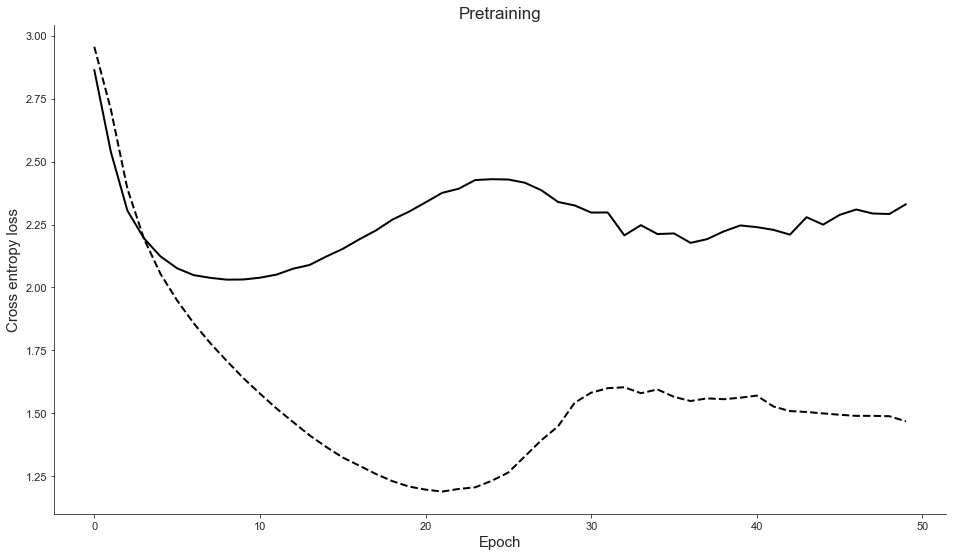

In [57]:
# Pre-tr learning curves
linewidth=2
sns_styleset()
fig = plt.figure(figsize = (16, 9))

ax = fig.add_subplot(111)
ax.plot(range(50), np.mean(pre_tr_hist, axis=(0, 2))[2, :], \
         c = 'k', linewidth=linewidth)
ax.plot(range(50), np.mean(pre_tr_hist_tr, axis=(0, 2))[2, :], \
         '--', c = 'k', linewidth=linewidth)
ax.set_title('Pretraining', fontsize = 17)
ax.set_xlabel('Epoch', fontsize = 15)
ax.set_ylabel('Cross entropy loss', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.tick_params(axis='both', which='minor', labelsize=11)
sns.despine()

#plt.savefig('figures/Bottleneck_Learning_Curves_Pretraining_LASSO.png', dpi = 200)

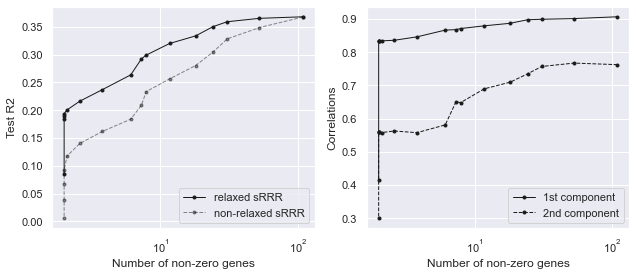

In [60]:
import warnings
sns_styleset()
def plot_cv_results(filename):
    with open(filename, 'rb') as f:
        r2, r2_relaxed, r2_tr, r2_relaxed_tr, nonzeros, corrs, corrs_relaxed = pickle.load(f)
    
    # suppressing "mean of empty slice" warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        n = np.nanmean(nonzeros, axis=0)[0, :]
        cr = np.nanmean(r2_relaxed, axis=0)[0, :]
        c = np.nanmean(r2, axis=0)[0, :]
        c1 = np.nanmean(corrs_relaxed, axis=0)[0,:,0]
        c2 = np.nanmean(corrs_relaxed, axis=0)[0,:,1]
    sns.set()
    plt.figure(figsize=(9,4))
    plt.subplot(121)
    plt.plot(n, cr, '.-', c = 'k', linewidth=1)
    plt.gca().set_prop_cycle(None)
    plt.plot(n, c, '.--', c = 'k', linewidth=1, alpha=.5)
    plt.xscale('log')
    plt.xlabel('Number of non-zero genes')
    plt.ylabel('Test R2')
    plt.legend(['relaxed sRRR', 'non-relaxed sRRR'])

    plt.subplot(122)
    plt.plot(n, c1, '.-', c = 'k', linewidth=1)
    plt.gca().set_prop_cycle(None)
    plt.plot(n, c2, '.--', c = 'k', linewidth=1)
    plt.xscale('log')
    plt.xlabel('Number of non-zero genes')
    plt.ylabel('Correlations')
    plt.legend(alphas)
    plt.legend(['1st component', '2nd component'])
    plt.tight_layout()

plot_cv_results('KerasSavedModels/sRRR_vs_Bottleneck_rank2_CV_lasso.pickle')

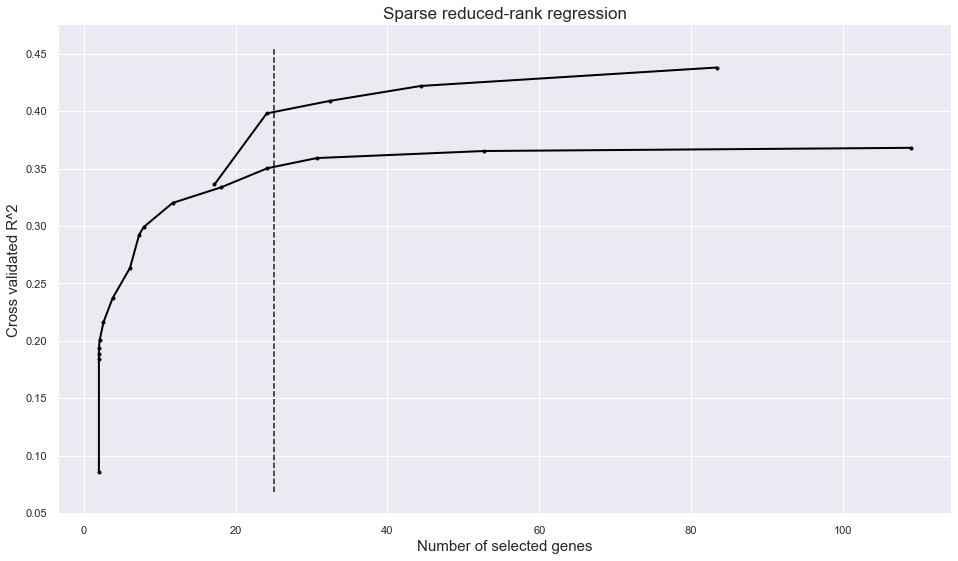

In [62]:
linewidth = 2
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(111)
    # suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    cr_2 = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    cr_16= np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]
# r2_sRRR_relaxed_rank2[r2_sRRR_relaxed_rank2==0]=np.nan
# r2_sRRR_relaxed_rank2_ =  np.nanmean(r2_sRRR_relaxed_rank2, axis = 0)
# r2_sRRR_relaxed_rank16[r2_sRRR_relaxed_rank16==0]=np.nan
# r2_sRRR_relaxed_rank16_ =  np.nanmean(r2_sRRR_relaxed_rank16, axis = 0)

# ax.plot(lambdas[np.nonzero(r2_sRRR_relaxed_rank16_[0, :])], \
#              r2_sRRR_relaxed_rank16_[0, :][np.nonzero(r2_sRRR_relaxed_rank16_[0, :])], '.-', \
#              c = np.array([0, 0, 0]) / 256, linewidth = linewidth, \
#              label = 'r=16')
# ax.plot(lambdas[np.nonzero(r2_sRRR_relaxed_rank2_[0, :])], \
#              r2_sRRR_relaxed_rank2_[0, :][np.nonzero(r2_sRRR_relaxed_rank2_[0, :])], '.-', \
#              c = np.array([105, 105, 105])/256, linewidth = linewidth, \
#              label = 'r=2')
ax.plot(n_2, cr_2, '.-', c = np.array([0, 0, 0])/256, linewidth=2)
ax.plot(n_16[1:], cr_16[1:], '.-', c = np.array([0, 0, 0]) / 256, linewidth=2)
ax.set_xlabel('Number of selected genes', fontsize = 15)
ax.set_ylabel('Cross validated R^2', fontsize = 15)
ax.set_title('Sparse reduced-rank regression', fontsize = 17)
ax.tick_params(axis='both', which='major', labelsize=11, length=8)
ax.tick_params(axis='both', which='minor', labelsize=11, length=8)
ax.vlines(x=25,ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyles='dashed')
sns.despine()

#plt.savefig('figures/Bottleneck_sRRR_lasso.png', dpi=200)

In [112]:
r2_straight_regr_hist_tr.shape

(3, 1, 5, 200)

In [113]:
r2_freeze_unfreeze_hist_tr.shape

(3, 4, 5, 200)

In [114]:
l2_params

array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04])

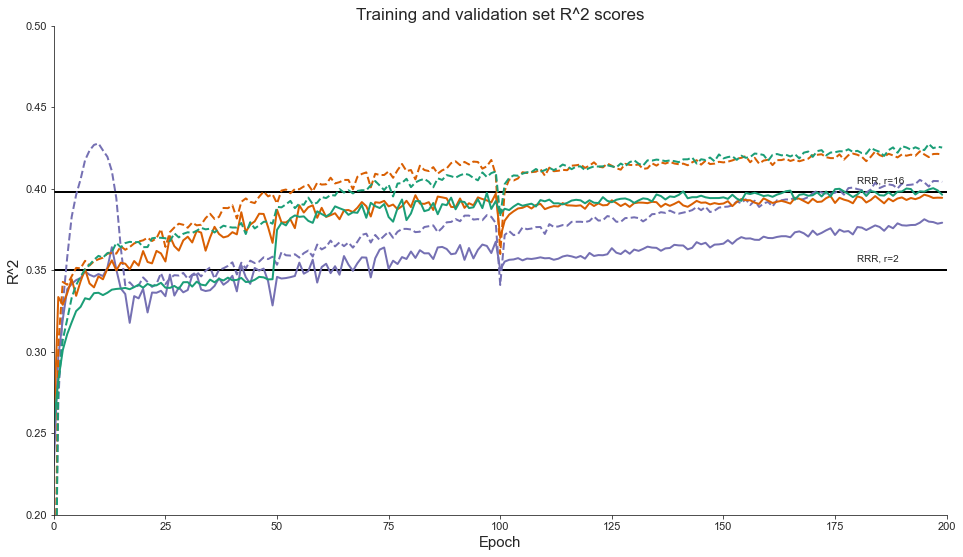

In [130]:
# The learning curves for our favourite model: pre-tr + train last 4 layers only + train all + prune
linewidth = 2

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

epochs_used = 200
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(111)

ax.plot(range(epochs_used), np.mean(r2_straight_regr_hist_tr, axis = (0, 1, 2)), \
         '--', c = '#7570b3', linewidth=linewidth)
ax.plot(range(epochs_used), np.mean(r2_straight_regr_hist, axis = (0, 1, 2)), \
         c = '#7570b3', linewidth=linewidth)
ax.plot(range(epochs_used), np.mean(r2_pretr_straight_regr_hist_tr, axis = (0, 1, 2)), \
         '--', c = '#d95f02', linewidth=linewidth)
ax.plot(range(epochs_used), np.mean(r2_pretr_straight_regr_hist, axis = (0, 1, 2)), \
         c = '#d95f02', linewidth=linewidth)
ax.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr, axis = (0, 2))[2, :], \
         '--', c = '#1b9e77', linewidth=linewidth)
ax.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist, axis = (0, 2))[2, :], \
         c = '#1b9e77', linewidth=linewidth)
ax.hlines(r_rank16_r[np.isclose(n_rank16, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax.hlines(r_rank2_r[np.isclose(n_rank2, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax.annotate('RRR, r=16', (180, r_rank16_r[np.isclose(n_rank16, 25, atol=3)]+0.005))
ax.annotate('RRR, r=2', (180, r_rank2_r[np.isclose(n_rank2, 25, atol=3)]+0.005))
ax.set_ylim([0.2, 0.5])
ax.set_xlim([0, 200])
ax.set_title('Training and validation set R^2 scores', fontsize = 17)
ax.set_xlabel('Epoch', fontsize = 15)
ax.set_ylabel('R^2', fontsize = 15)
#ax.legend(loc='lower right', fontsize = 11)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.tick_params(axis='both', which='minor', labelsize=11)
sns.despine()

#plt.savefig('figures/Bottleneck_Learning_Curves_LASSO.png', dpi=200)

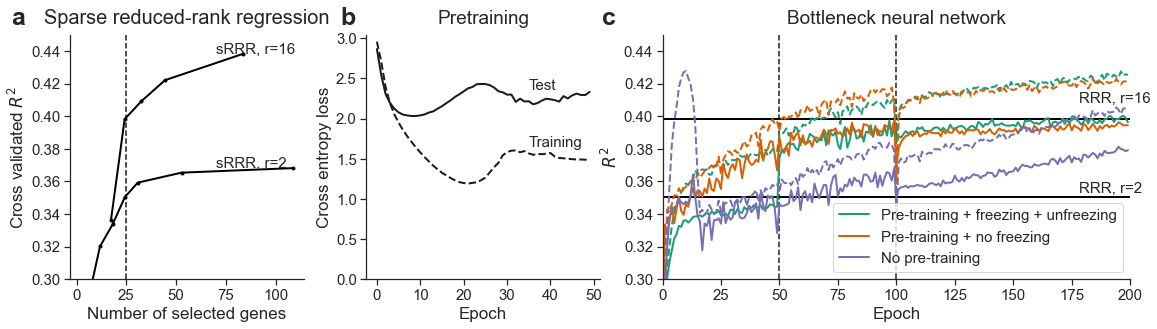

In [227]:
# All together in one plot
linewidth = 2
sns_styleset()

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    cr_2 = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    cr_16= np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]
    
    

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

# All together in one plot for the paper
fig = plt.figure(figsize=(19, 4.5))
widths = [1, 1, 2]
heights = [1]
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths,
                          height_ratios=heights)
ax1 = fig.add_subplot(spec[0, 0])
ax1.plot(n_2, cr_2, '.-', c = np.array([0, 0, 0])/256, linewidth=2)
ax1.plot(n_16[1:], cr_16[1:], '.-', c = np.array([0, 0, 0]) / 256, linewidth=2)
ax1.set_ylim([0.3,0.45])
ax1.set_xlabel('Number of selected genes', fontsize = 17)
ax1.set_ylabel(r'Cross validated $R^2$', fontsize = 17)
ax1.set_title('Sparse reduced-rank regression', fontsize = 20, y=1.02)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax1.vlines(x=25, ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], linestyles='dashed')
ax1.annotate('sRRR, r=16', (70, np.max(cr_16)+0.0003), fontsize=15)
ax1.annotate('sRRR, r=2', (70, np.max(cr_2)+0.0003), fontsize=15)


ax2 = fig.add_subplot(spec[0, 1])
ax2.plot(range(50), np.mean(pre_tr_hist_tr, axis=(0, 2))[2, :], \
         '--', c = 'k', linewidth=linewidth)
ax2.plot(range(50), np.mean(pre_tr_hist, axis=(0, 2))[2, :], \
         c = 'k', linewidth=linewidth)
ax2.set_title('Pretraining', fontsize = 19, y=1.02)
ax2.set_xlabel('Epoch', fontsize = 17)
ax2.set_ylabel('Cross entropy loss', fontsize = 17)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='minor', labelsize=15)
ax2.set_ylim([0, ax2.get_ylim()[1]])
ax2.annotate('Training', (35, 1.65), fontsize=15)
ax2.annotate('Test', (35, 2.36), fontsize=15)
ax2.set_xticks(np.arange(0, 60, 10))

epochs_used=200
ax3 = fig.add_subplot(spec[0, 2])
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr, axis=(0, 2))[2, :], \
         '--', c = '#1b9e77', linewidth=linewidth)
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist, axis=(0, 2))[2, :], \
         c = '#1b9e77', linewidth=linewidth, label='Pre-training + freezing + unfreezing')
ax3.plot(range(epochs_used), np.mean(r2_pretr_straight_regr_hist_tr, axis=(0, 1, 2)), \
         '--', c = '#d95f02', linewidth=linewidth)
ax3.plot(range(epochs_used), np.mean(r2_pretr_straight_regr_hist, axis=(0, 1, 2)), \
         c = '#d95f02', linewidth=linewidth, label='Pre-training + no freezing')
ax3.plot(range(epochs_used), np.mean(r2_straight_regr_hist_tr, axis=(0, 1, 2)), \
         '--', c = '#7570b3', linewidth=linewidth)
ax3.plot(range(epochs_used), np.mean(r2_straight_regr_hist, axis=(0, 1, 2)), \
         c = '#7570b3', linewidth=linewidth, label='No pre-training')
ax3.hlines(r_rank16_r[np.isclose(n_rank16, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax3.hlines(r_rank2_r[np.isclose(n_rank2, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax3.set_ylim([0.3,0.45])
ax3.set_xlim([0,200])
ax3.set_xticks(np.arange(0, 225, 25))
ax3.annotate('RRR, r=16', (178, r_rank16_r[np.isclose(n_rank16, 25, atol=3)]+0.01), fontsize=15)
ax3.annotate('RRR, r=2', (178, r_rank2_r[np.isclose(n_rank2, 25, atol=3)]+0.003), fontsize=15)
ax3.set_title('Bottleneck neural network', fontsize = 19, y=1.02)
ax3.set_xlabel('Epoch', fontsize = 17)
ax3.set_ylabel(r'$R^2$', fontsize = 17)
ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.tick_params(axis='both', which='minor', labelsize=15)
ax3.legend(loc='lower right', fontsize=15)
ax3.vlines(x=50, ymin=ax3.get_ylim()[0], ymax=ax3.get_ylim()[1], linestyles='dashed')
ax3.vlines(x=100, ymin=ax3.get_ylim()[0], ymax=ax3.get_ylim()[1], linestyles='dashed')

plt.text(-0.25, 1.04, 'a', transform = ax1.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.11, 1.04, 'b', transform = ax2.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.13, 1.04, 'c', transform = ax3.transAxes, fontsize=25, fontweight='bold')
sns.despine()

plt.savefig('figures/Lasso_training_curves.pdf', bbox_inches='tight',
    pad_inches=0)
plt.savefig('figures/Lasso_training_curves.png', bbox_inches='tight',
    pad_inches=0)

# Extensions

How many nodes in the bottleneck do we need to really perform clearly above (and relatively soon above) the full rank linear model?

In [234]:
importlib.reload(bottleneck_networks)

<module 'bottleneck_networks' from '/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/bottleneck_revision/bottleneck_networks.py'>

In [235]:
from bottleneck_networks import ClassificationPreTrain

Make sure you change the names of the files that are being named in bottleneck_networks.py . When you do this classification you'll need the correct files to then do freeze unfreeze pruning afterwards.

In [236]:
# What about using different amount of nodes in the bottleneck?
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs


t = time.time()
np.random.seed(seed)
n = X_no_low_qual.shape[0]
ind = np.random.permutation(n)
X = X_no_low_qual[ind,:]
Y = Y_no_low_qual[ind,:]
clusters_ = clusters[ind]
ind_pre_train = ind_pre_training_clusters[ind]

CE_loss = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0]))
CE_loss_tr = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0]))
pre_tr_hist = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0], epochs))
pre_tr_hist_tr = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0], epochs))


for u,f in enumerate(range(2,12,2)):
    nodes_list=[512, 128, f, 128, 512]
    print('Bottleneck with {} nodes'.format(f))
    # CV folds
    for cvfold in range(folds):
        print('\nCVFOLD: ', cvfold)
        indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
        indtrain = np.setdiff1d(np.arange(n), indtest)
        x_train = np.copy(X[indtrain,:])
        clusters_train = np.copy(clusters_[indtrain])
        y_train = np.copy(Y[indtrain,:])
        x_test = np.copy(X[indtest,:])
        clusters_test = np.copy(clusters_[indtest])
        y_test = np.copy(Y[indtest,:])

        # Mean centering (like sRRR)
        X_mean = np.mean(x_train, axis=0)
        x_train -= X_mean
        x_test -= X_mean
        Y_mean = np.mean(y_train, axis=0)
        y_train -= Y_mean
        y_test -= Y_mean

        # In our training set we now look for a 'pretraining' training and test data set that we can use
        # for pretraing a classification network, i.e. picking the best model will be dones with a seperate val set in our
        # training set for regression.

        x_train_pre_tr = x_train[ind_pre_train[indtrain], :]
        clusters_train_pre_tr = clusters_train[ind_pre_train[indtrain]]

        pre_train_size = 0.6
        train_cnt = round(x_train_pre_tr.shape[0]*pre_train_size)
        x_train_pre_tr_ = x_train_pre_tr[:train_cnt, :]
        x_test_pre_tr_ = x_train_pre_tr[train_cnt:, :]
        clusters_train_pre_tr_ = clusters_train_pre_tr[:train_cnt]
        clusters_test_pre_tr_ = clusters_train_pre_tr[train_cnt:]

        for i, l2 in enumerate(l2_params):
            #print('Ridge penalty: ', l2)
            for j, l1 in enumerate(l1_params):
                #print('Lasso penalty: ', l1)


                input_dim = x_train.shape[1]
                output_dim = to_categorical(clusters_train_pre_tr).shape[1]
                BN_Classification = ClassificationPreTrain(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, \
                                                           output_dim=output_dim, nodes_list=nodes_list)
                CE_train, CE_test, train_hist, test_hist = BN_Classification.train(x_train=x_train_pre_tr_, \
                                                                                   cluster_train=clusters_train_pre_tr_, \
                                                                                   x_test=x_test_pre_tr_, \
                                                                                   cluster_test=clusters_test_pre_tr_, \
                                                                                   epochs=epochs, bs=bs, patience=patience, \
                                                                                   cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                                   verbose=0)
                CE_loss[u, cvfold, j, i] = CE_test
                CE_loss_tr[u, cvfold, j, i] = CE_train
                pre_tr_hist[u, cvfold, j, i] = test_hist
                pre_tr_hist_tr[u, cvfold, j, i] = train_hist
                #print('Test CE loss (pre-trainin): ', CE_loss[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

Bottleneck with 2 nodes

CVFOLD:  0
[INFO] training network...
437/437 [==============================] - 0s 100us/sample - loss: 51.9238 - categorical_crossentropy: 1.9702

CVFOLD:  1
[INFO] training network...
437/437 [==============================] - 0s 101us/sample - loss: 52.2691 - categorical_crossentropy: 2.0745

CVFOLD:  2
[INFO] training network...
437/437 [==============================] - 0s 89us/sample - loss: 51.6368 - categorical_crossentropy: 2.0894

CVFOLD:  3
[INFO] training network...
437/437 [==============================] - 0s 96us/sample - loss: 55.2955 - categorical_crossentropy: 2.0360

CVFOLD:  4
[INFO] training network...
437/437 [==============================] - 0s 105us/sample - loss: 55.3839 - categorical_crossentropy: 1.9621

CVFOLD:  5
[INFO] training network...
437/437 [==============================] - 0s 94us/sample - loss: 55.4741 - categorical_crossentropy: 2.0769

CVFOLD:  6
[INFO] training network...
437/437 [==============================] - 0s 

In [237]:
from bottleneck_networks import FreezeUnfreeze

In [238]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
unfreeze = [False, False, True, True, True, True] # last 4 layers can be trained only first
prune=True

r2_before_unfreezing = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0]))
r2_before_unfreezing_tr = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_tr = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_ap = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_ap_tr = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0]))
r2_freeze_unfreeze_hist = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_freeze_unfreeze_hist_tr = np.zeros((len(range(2,12,2)), folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = X_no_low_qual.shape[0]
ind = np.random.permutation(n)
X = X_no_low_qual[ind,:]
Y = Y_no_low_qual[ind,:]

for u,f in enumerate(range(2,12,2)):
    nodes_list=[512, 128, f, 128, 512]
    print('Bottleneck with {} nodes'.format(f))
    # CV folds
    for cvfold in range(folds):
        print('\nCVFOLD: ', cvfold)
        indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
        indtrain = np.setdiff1d(np.arange(n), indtest)
        x_train = np.copy(X[indtrain,:])
        y_train = np.copy(Y[indtrain,:])
        x_test = np.copy(X[indtest,:])
        y_test = np.copy(Y[indtest,:])

        # Mean centering (like sRRR)
        X_mean = np.mean(x_train, axis=0)
        x_train -= X_mean
        x_test -= X_mean
        Y_mean = np.mean(y_train, axis=0)
        y_train -= Y_mean
        y_test -= Y_mean

        input_dim = x_train.shape[1]
        output_dim = y_train.shape[1]

        for i, l2 in enumerate(l2_params):
            #print('Ridge penalty: ', l2)
            for j, l1 in enumerate(l1_params):
                #print('Lasso penalty: ', l1)

                pre_trained_weights_h5 = 'KerasSavedModels/Classification_last_weights_{}_{}_{}_{}.h5'.format(cvfold, j, i, \
                                                                                                             nodes_list[2])
                input_dim = x_train.shape[1]
                output_dim = y_train.shape[1]
                BN_PreTrFreezeUnfreeze = FreezeUnfreeze(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, output_dim=output_dim, \
                                                           unfreeze = unfreeze, \
                                                           pre_trained_weights=pre_trained_weights, \
                                                           pre_trained_weights_h5=pre_trained_weights_h5, \
                                                           nodes_list=nodes_list)
                r2_before_unfreezing_train, r2_before_unfreezing_test, \
                    r2_after_unfreezing_train, r2_after_unfreezing_test, \
                    r2_after_unfreezing_train_ap, r2_after_unfreezing_test_ap, \
                    train_hist, test_hist = BN_PreTrFreezeUnfreeze.train(x_train=x_train, y_train=y_train, \
                                                                        x_test=x_test, y_test=y_test, \
                                                                        epochs=epochs, bs=bs, patience=patience, \
                                                                        cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                        prune=prune, geneNames=geneNames, \
                                                                        verbose=0)
                r2_before_unfreezing[u, cvfold, j, i] = r2_before_unfreezing_test
                r2_before_unfreezing_tr[u, cvfold, j, i] = r2_before_unfreezing_train
                r2_after_unfreezing[u, cvfold, j, i] = r2_after_unfreezing_test
                r2_after_unfreezing_tr[u, cvfold, j, i] = r2_after_unfreezing_train
                r2_after_unfreezing_ap[u, cvfold, j, i] = r2_after_unfreezing_test_ap
                r2_after_unfreezing_ap_tr[u, cvfold, j, i] = r2_after_unfreezing_train_ap
                r2_freeze_unfreeze_hist[u, cvfold, j, i] = test_hist
                r2_freeze_unfreeze_hist_tr[u, cvfold, j, i] = train_hist
                #print('Test R^2 score (before unfreezing): ', r2_before_unfreezing[cvfold, j, i])
                #print('Test R^2 score (after unfreezing): ', r2_after_unfreezing[cvfold, j, i])
                #print('Test R^2 score (after unfreezing and after pruning): ', r2_after_unfreezing_ap[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

Bottleneck with 2 nodes

CVFOLD:  0
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Htr3a' 'Dusp14' 'Calb2' 'Col24a1' 'Ndst3' 'Cacna1e' 'Nell2' 'Kcnc2'
 'Unc13c' 'Plch2' 'Gabrd' 'Slc6a1' 'Enpp2' 'Elfn1' 'Kcnip2' 'Cplx1'
 'Sparcl1' 'Gm49948' 'Lamp5' 'Ndn' 'Gad1' 'Tac2' 'Pvalb' 'Sst' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0.39792996644973755
Test R^2 before unfreezing:  0.3890771269798279
Train R^2 after unfreezing:  0.4455087184906006
Test R^2 after unfreezing:  0.4502079486846924
Train R^2 after unfreezing and pruning:  0.4306636452674866
Test R^2 after unfreezing and pruning:  0.45798277854919434

CVFOLD:  1
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Mybpc1' 'Cd81' 'Nars' 'Cacna2d3' 'Parm1' 'Elmo1' 'Cplx1' 'Sema5a'
 'Synpr' 'Grip1' 'Cplx3' 'Rab3b' 'Egfr' 'Fxyd6' 'Cbln2' 'Reln' 'Plch2'
 'Ptk2b' 'Coro6' 'Atp1a3' 'Slc6a1' 'Tafa1' 'Erbb4' 'Pvalb' 'Gad1']
[INFO] training network...
Train R

[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Satb1' 'Gabrd' 'Phactr1' 'Afap1' 'Chat' 'Mas1' 'Cacna1e' 'Plch2'
 'Gm49948' 'Enpp2' 'Cbln2' 'Lamp5' 'Gabra1' 'Tac2' 'Ndst3' 'Ndn' 'Galnt14'
 'Erbb4' 'Cplx1' 'Fxyd6' 'Htr3a' 'Gad1' 'Sst' 'Vip' 'Pvalb']
[INFO] training network...
Train R^2 before unfreezing:  0.4474714398384094
Test R^2 before unfreezing:  0.39325690269470215
Train R^2 after unfreezing:  0.4818621277809143
Test R^2 after unfreezing:  0.4337710738182068
Train R^2 after unfreezing and pruning:  0.45070433616638184
Test R^2 after unfreezing and pruning:  0.42544353008270264

CVFOLD:  4
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Mas1' 'Cbln2' 'Unc13c' 'Enpp2' 'Tac2' 'Sparcl1' 'Pamr1' 'Fxyd6' 'Tafa1'
 'Atp1a3' 'Plch2' 'Coro6' 'Cplx1' 'Phactr1' 'Ndst3' 'Gm49948' 'Galnt14'
 'Ndn' 'Lamp5' 'Htr3a' 'Gad1' 'Erbb4' 'Sst' 'Pvalb' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0.4629243612289428

[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Cxcl14' 'Cdh13' 'Coro6' 'Chat' 'Tafa1' 'Atp1a3' 'Lingo2' 'Pik3r5'
 'Cplx1' 'Cplx3' 'Tac2' 'Elmo1' 'Fxyd6' 'Enpp2' 'Cbln2' 'Calb1' 'Ndst3'
 'Ndn' 'Erbb4' 'Htr3a' 'Gad1' 'Lamp5' 'Pvalb' 'Sst' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0.48647594451904297
Test R^2 before unfreezing:  0.38380658626556396
Train R^2 after unfreezing:  0.5216321647167206
Test R^2 after unfreezing:  0.4453487992286682
Train R^2 after unfreezing and pruning:  0.48054367303848267
Test R^2 after unfreezing and pruning:  0.42186224460601807

CVFOLD:  7
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Tafa1' 'Phactr1' 'Afap1' 'Lingo2' 'Pcdh7' 'Npy1r' 'Gm49948' 'Elmo1'
 'Atp1a3' 'Calb1' 'Satb1' 'Cplx1' 'Enpp2' 'Ndst3' 'Fxyd6' 'Htr3a' 'Tac2'
 'Galnt14' 'Ndn' 'Erbb4' 'Lamp5' 'Sst' 'Gad1' 'Vip' 'Pvalb']
[INFO] training network...
Train R^2 before unfreezing:  0.4741266965866089
Tes

[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Plch2' 'Satb1' 'Pamr1' 'Enpp2' 'Gabra1' 'Coro6' 'Reln' 'Fxyd6' 'Tac2'
 'Elmo1' 'Ndst3' 'Pde1a' 'Galnt14' 'Cplx1' 'Ndn' 'Pdyn' 'Erbb4' 'Cbln2'
 'Htr3a' 'Lamp5' 'Pvalb' 'Gad1' 'Sst' 'Calb1' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0.4866989850997925
Test R^2 before unfreezing:  0.40547168254852295
Train R^2 after unfreezing:  0.5169898569583893
Test R^2 after unfreezing:  0.45280760526657104
Train R^2 after unfreezing and pruning:  0.49088799953460693
Test R^2 after unfreezing and pruning:  0.4157329201698303
Bottleneck with 10 nodes

CVFOLD:  0
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Pde1a' 'Npnt' 'Gm43670' 'Reln' 'Scg2' 'Gm49948' 'Atp1a3' 'Elmo1'
 'Sparcl1' 'Plch2' 'Enpp2' 'Htr3a' 'Galnt14' 'Pdyn' 'Fxyd6' 'Erbb4' 'Ndn'
 'Thsd7a' 'Cplx1' 'Lamp5' 'Tac2' 'Gad1' 'Sst' 'Pvalb' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0.

In [239]:
with open('KerasSavedModels/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso_multiple_nodes.pickle', 'wb') as f:
    pickle.dump([r2_before_unfreezing, r2_before_unfreezing_tr, \
                 r2_after_unfreezing, r2_after_unfreezing_tr, \
                 r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
                 r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr], f)

In [240]:
with open('KerasSavedModels/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso_multiple_nodes.pickle', 'rb') as f:
    r2_before_unfreezing, r2_before_unfreezing_tr, \
    r2_after_unfreezing, r2_after_unfreezing_tr, \
    r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
    r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr = pickle.load(f)

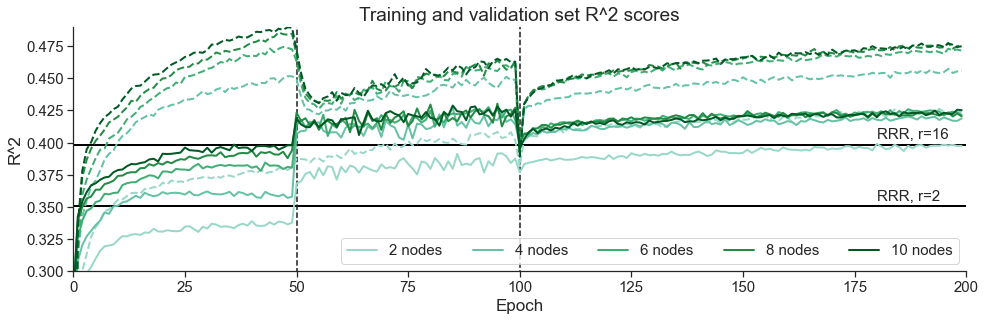

In [252]:
# The learning curves for our favourite model: pre-tr + train last 4 layers only + train all + prune
linewidth = 2

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

epochs_used = 200
fig = plt.figure(figsize = (16, 4.5))
ax = fig.add_subplot(111)
colours = ['#99d8c9', '#66c2a4', '#41ae76', '#238b45', '#005824']
for u,f in enumerate(range(2,12,2)):
    ax.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr, axis = (1, 2))[u, 0, :], \
             '--', c = colours[u], linewidth=linewidth, label=None)
    ax.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist, axis = (1, 2))[u, 0, :], \
             c = colours[u], linewidth=linewidth, label='{} nodes'.format(f))
ax.hlines(r_rank16_r[np.isclose(n_rank16, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax.hlines(r_rank2_r[np.isclose(n_rank2, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax.annotate('RRR, r=16', (180, r_rank16_r[np.isclose(n_rank16, 25, atol=3)]+0.005), fontsize=15)
ax.annotate('RRR, r=2', (180, r_rank2_r[np.isclose(n_rank2, 25, atol=3)]+0.005), fontsize=15)
ax.vlines(x=50, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyles='dashed')
ax.vlines(x=100, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyles='dashed')
ax.set_ylim([0.3, 0.49])
ax.set_xlim([0, 200])
ax.set_title('Training and validation set R^2 scores', fontsize = 19)
ax.set_xlabel('Epoch', fontsize = 17)
ax.set_ylabel('R^2', fontsize = 17)
ax.legend(loc='lower right', ncol=5, fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
sns.despine()

plt.savefig('figures/Lasso_training_curves_different_nodes.pdf', bbox_inches='tight',
    pad_inches=0)
plt.savefig('figures/Lasso_training_curves_different_nodes.png', bbox_inches='tight',
    pad_inches=0)